# Deductive analysis of PERC Proceedings articles at scale using text embeddings

**Halvor Tyseng, Jonas Timmann Mjaaland, Markus Fleten Kreutzer and Tor Ole B. Odden**
Center for Computing in Science Education and Center for Interdisciplinary Education, University of Oslo, Norway.

**Disclaimer:** Usage of the method and code below will require a citation of this comptuational essay. Citation details pertaining to this research are found in the CITATION.cff file.

MIT License

Copyright (c) 2024 halvorty

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

<br />

### Table of contents
1. [Introduction](#one) <br>
    1.A. [Imports](#one_a) <br>
2. [Description of the Method](#two)<br>
    2.A. [Distance Metrics](#two_a)<br>
    2.B. [Defining centroids](#two_b)<br>
    2.C. [Python implementation](#two_c)<br>
    2.D. [Interpreting resulting scores and quantifying topic prevalence](#two_d)<br>
    2.E. [Python implementation](#two_e)<br>
3. [LDA-Derived Categories](#three)<br>
    3.A. [Loading data and examining the datasets](#three_a)<br>
    3.B. [Indices](#three_b)<br>
    3.C. [Deciding on distance metrics, scaling functions, and hyperparameter values](#three_c)<br>
    3.D. [Investing the JS-divergence distribution among articles](#three_d)<br>
    3.E. [Investigating LDA-based embeddings score distribution](#three_e)<br>
    3.G. [Face validity check: reclassified articles](#three_g)<br>
    3.H. [Plotting topic prevelence as a function of time](#three_h)<br>
4. [Embeddings Analysis using Researcher-Derived Categories](#four)<br>
    4.A. [Loading new data](#four_a)<br>
    4.B. [Indices](#four_b)<br>
    4.C. [Distance metrics, scaling functions, and hyperparameters](#four_c)<br>
    4.D. [Face validity: articles with high topic scores, mean topics scores, and approximately 50% topic scores](#four_d)<br>
    4.E. [Plotting topic prevelence as a function of time](#four_e)<br>
    4.F. [Plotting cumulative prevalence as a function of time, and evaluating sensitivity to centroid choice](#four_f)<br>
5. [Discussion and Conclusion](#five)<br>
    5.A. [Reflections on the method](#five_a)<br>
    5.B. [Future work and applications](#five_b)<br>
    5.C. [Conclusion](#five_c)<br>
6. [Citations](#citations)<br>

<a class="anchor" id="one"></a>
# 1. Introduction 

The motivation behind this work was twofold. On one hand, we saw room for improvement on the current state of the art method for topic modeling in text analysis, Latent Dirichlet Allocation (LDA), which has drawbacks such as a relying of a bag of words approach and requiring a significant amount of data to produce coherent topics. Simultaneously, we saw opportunities for to leverage improvements in transformer based Large Language Models for the purposes of qualitative analysis of text data.

To perform this analysis, we have used the jina-embeddings-v2-small-en text-embedding model from Jina AI to convert the textual data of the articles into numerical vector data called “embeddings”. Every article gets a corresponding 512-dimensional embedding vector that encapsulates some amount of its semantic meaning by projecting it into a semantic space that mathematically represents (some amount of) the meaning of the text. 

The goal of this project is to use embeddings to aid in deductive qualitative analysis of text data. In deductive qualitative analysis, a researcher reviews a set of data (often textual responses to surveys, interview trascripts, scientific articles, etc.) and tries to classify them according to some pre-defined classification or coding scheme. This work is typically very time-consuming, as reading through data and making analytic decisions must be done by hand. Current NLP methods like embeddings, which allow one to represent, compare, and manipulate text using vector operations, offer interesting opportunities to automatize and/or scale up this kind of work.

The method presented here is a first step in this direction. Because it is deductive, it requires pre-defined topics, which the researcher should figure out ahead of time. It also requires the researcher to have some representative examples of text that fits into each topic—that is, sample texts that exemplify each category.

We will present the method in the context of a common application of deductive qualitative analysis: a literature review. Specifically, we will be working with approximately 1750 articles from the [Physics Education Research Conference Proceedings](https://www.per-central.org/perc/Proceedings.cfm). These articles were chosen first because they are open access (available as pre-prints and/or under a Creative Commons License, with written permission from the publisher to do NLP work); second, because the research team has familiarity with the field of physics education research; and third, because they have been [previously inductively analyzed using LDA](https://journals.aps.org/prper/abstract/10.1103/PhysRevPhysEducRes.16.010142), which allows us to compare and benchmark the current method against prior research.

This computational essay is a companion to the research paper *Using Text Embeddings for Deductive Qualitative Research at Scale in Physics Education*, by Tor Ole Odden, Halvor Tyseng, Jonas Timmann Mjaaland, Markus Fleten Kreutzer, and Anders Malthe-Sørenssen at the University of Oslo, Norway. The article is available on arXiv and is currently under submission to Physical Review Physics Education Research. We will guide interested researchers through the different steps of the method, start to finish, and reproduce all figures from the accompanying paper (as well as a few that were not included due to space considerations). Our analysis goes in three sections:

1. **Importing libraries, describing the method, setting up the dataframes, and general analysis preparations.**
2. **Deductive literature review based on LDA-derived categories.**
3. **Deductive literature review based on domain expert-derived categories.**
 

<a class="anchor" id="one_a"></a>
## 1.A. Imports

We begin by importing our key libraries: numpy and pandas for data handling, scipy for data analysis, and matplotlib, string, and seaborn for plotting:

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sc

# Special imports for plots
import string
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors

<a class="anchor" id="two"></a> 
# 2. Description of the method

The method used in this analysis begins by creating embeddings of texts—that is, vector-based representations of the meaning of the text in a high-dimensional (512 dimension) "meaning space" that has been defined by our chosen large-language model. Next, we define specific locations—centroids—within that space that correspond to researcher-defined topics. To make these centroids, we pick a selection of texts that represent specific topics or classes, and average their embeddings vectors. Next, we measure the distance from each text to each of these centroids, and use a scaling and transformation function to turn these distances into topic scores. Finally, we interpret the resulting scores and use them to quantify the prevalence of these topics in the literature as a function of time. We unpack each of these steps in more detail below.

<a class="anchor" id="two_a"></a> 
## 2.A. Creating embeddings
In this notebook, we have already created embeddings of the texts under analysis. These embeddings will be imported as datafiles later on. 

<a class="anchor" id="two_b"></a> 
## 2.B. Defining centroids
The centroid for a topic is defined based on a set of representative texts. Below we use around 10-15 articles to define each centroid, take the mean of these representative articles' embedding vectors. The function we use to calculate these centroids, ```embedding_score```, therefore takes in the indices of these representative articles as an argument, and calculates the mean of their corresponding vectors. The centroids are structured an array, with the order of centroids matching the order of the sets of indices passed to the function.

<a class="anchor" id="two_c"></a> 
## 2.C. Measuring and scaling distances to make topic scores
The next step is to measure the similarity or distance of each article to each centroid, and turn this measure into a topic score. Since we are operating in a space with 512 with dimensions, it is possible to choose from a variety of metrics for measuring the distance. Common metrics include Euclidean distance, Manhattan (or ‘cityblock’) distance, and Cosine Similarity (dot product). 

**Euclidean distance** calculates the distance between two points by finding the shortest line that can be drawn between said points. For higher dimensions the metric is defined by:

$\large d(p,q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}$

**Cosine similarity** measures the angle between two non-zero vectors in space. For this metric, the magnitude of vectors is irrelevant, since it is essentially finding the projection of one vector onto another (this is no issue in the present analysis regardless, as the embedding vectors are normalized before any metric is applied). The definition of cosine similarity is:

$\large \cos(\theta) = \frac{\sum_{i=1}^{n} A_i \cdot B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}$

**Manhattan distance**, also known as "Cityblock", simply sums the absolute value of each dimension as the distance. Definition:

$\large d(p,q) = \sum_{i=1}^{n} |p_i - q_i|$

Because the embeddings vectors live in a 512 dimensional space, we also need to take into account the ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality): that is, the fact that data and vectors in high dimensional space do not behave the same as in low dimensional space. For instance, with increasing dimensions, [each point ends up being nearly equidistant from every other point](https://link.springer.com/chapter/10.1007/3-540-44503-X_27)[[1]](#ref1). Furthermore, the 512-dimensional space we are using is meant to encapsulate many different kinds of textual meanings, since any kind of text (from newspaper articles to recipes to Biblical passages to technical documentation) can be turned into an embedding. Because of this, it is expected that all of the articles used in the present analysis will occupy a relatively small slice of the overall 512-dimensional meaning space, and consequently differences between text vectors will be frelatively small. 

Additionally, in the present analysis we expect that distance will be inversely related to topic score, since text embeddings vectors that lie closer to certain centroids should recieve higher topic scores for those centroids' topics.

To address these issue, we introduce a scaling function that both inverts the distance and magnifies the small differences between vectors. We have many choices of scaling function, but for the present analysis we have tried out two specific otpions: power-law scaling and the exponential scaling. They are calculated with the following functions:

For a calculated distance $x_{k}$ between a specific document $D$ and the centroid for a topic $k \in \{1,...K\}$, the topic score $T_{D,k}$ can be defined as:


$\large \text{Power law: } T_{D,k} = \frac{(x_{k})^\alpha}{\sum_{k=1}^{K}(x_{k})^\alpha}$

$\large \text{Exponential: } T_{D,k} = \frac{e^{(x_{k})\alpha}}{\sum_{k=1}^{K}(e^{(x_{k})\alpha}}$

Both alternatives include a tunable scaling variable $\alpha$. As we will demonstrate later, this hyperparameter determines how heterogeneous vs. homogeneous the topic scores will be. The higher the alpha value, the more often texts are classified as primarily 1-2 topics. Finding the an appropriate value for the alpha value is important, and will be a key point of our first analysis. 

The function ```embedding_score``` takes both the distance metric (as a string) and alpha value as arguments and returns an array of embedding scores.

<a class="anchor" id="two_d"></a>
## 2.D. Interpreting resulting scores and quantifying topic prevalence
An important part of both the analysis process is checking that the topic scores make sense, given what we know about the literature base, and also seeing what they can tell us about the development of the body of literature over time. We present multiple examples below of how we evaluated face validity of these scores and visualized changes in the PERC proceedings using two different sets of defined topics. 

<a class="anchor" id="two_e"></a> 
## 2.E. Python implementation
Below, we implement a function to calculate topic scores using embeddings.

In [2]:
def embedding_score(embedding_matrix, alpha, centroid_indices, metric, scaling, rounding=False): 
    """Calculates the scores for a given embedding matrix (n, d)
        and a list of indices for each centroid (k), listed together in
        centroid_indices. 

    Args:
        embedding_matrix np.array: The embedding matrix, shape (n, d)
        alpha (float): The scaling parameter
        centroid_indices (list): A list of lists of indices of the centroids
        metric (str): The metric used for calculating the distance 
        scaling (str): The scaling used for scaling the distances
        rounding (bool, optional): If True scores are rounded. Defaults to False.

    Returns:
        np.array: The embedding scores, shape (n, k)
    """
    
    # Check that the input is valid
    assert scaling in ["exponential", "power"]
    assert metric in ["cosine", "euclidean", "cityblock"]

    # Normalizing the embedding matrix
    embedding_matrix /= np.linalg.norm(embedding_matrix, axis=1)[:,None]
    
    # Calculating centroid vectors
    centroid = np.zeros((len(centroid_indices), len(embedding_matrix[0])))
    for i in range(len(centroid_indices)):
        embeddings_temp = np.array([embedding_matrix[index] for index in centroid_indices[i]])
        centroid[i] = np.mean(embeddings_temp, axis=0)
        
    # Calculating distances using scipy.spatial.distance.cdist function
    distances = sc.spatial.distance.cdist(embedding_matrix, centroid, metric=metric)
    
    # Scale and invert the distances according to the specified scaling
    if scaling == "exponential":
        score = 1/np.exp(alpha*distances)
    if scaling == "power":
        score = 1/(distances**alpha)
    
    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]
    
    # Round the scores to 2 decimals if specified
    if rounding:
        # Set all values below 0.01 to 0
        score[score <=0.01] = 0
        score /= score.sum(axis=1)[:,None]

    return score

<a class="anchor" id="three"></a> 
# 3. LDA-Derived Categories

Now, we show an example of how this method can be used to analyze the PERC proceedings literature. To begin, we will attempt to replicate a previous inductive literature review of the PERC proceedings, conducted using Latent Dirichlet Allocation (LDA) by [Odden et al. (2020)](https://journals.aps.org/prper/abstract/10.1103/PhysRevPhysEducRes.16.010142)[[2]](#ref3). Specifically, we will use the 10 topics from that study, and try to reproduce them by constructing centroids for each topic based on the 15 highest-scoring articles from each topic according to LDA.

<a class="anchor" id="three_a"></a> 
## 3.A. Loading data and examining the datasets

The dataset for this part of the analysis consists of the texts of 1745 articles from the PERC proceedings, 2001-2023. The embeddings of these articles have been created using the open source embedding model "jinaai/jina-embeddings-v2-small-en", downloaded from huggingface: [https://huggingface.co/jinaai/jina-embeddings-v2-small-en](https://huggingface.co/jinaai/jina-embeddings-v2-small-en).

For convenience, we have created these embeddings in a separate notebook and saved them into a DataFrame using pickle. 

Additionally, we have used the LDA topic scores from the Odden et al. (2020) analysis (which covers PERC proceedings articles 2001-2018)[[2]](#ref3), and used the Gensim LDA model from that analysis to socre the remaining articles from 2019-2023. These scores are also saved in a DataFrame using pickle.

We will load in two dataframes, ```df_embeddings``` and ```df_LDA```. In these dataframes, each row corresponds to an article. The two dataframes share the following columns:
- "filename": the filename of the article
- "year": the year the article was published
- "title": title of the article
- "authors": authors of the article

The dataframes are index-matched (i.e., the same indices correspond to the same papers in both dataframes), so we will use indices when comparing articles.

For the LDA dataframe ```df_LDA```, the following columns are included, which correspond to LDA's topic scores for each article:
- "Representation"
- "Problem Solving"
- 'Lab Instruction'
- 'Assessment (Concepts)' 
- 'K-12'
- 'Quantum Difficulties'
- 'Community and Identity' 
- 'Qualitative Theory'
- 'RBIS' 
- 'Assessment (Demog.)'

See Odden et al. (2020) for more detail on what these topics mean[[2]](#ref3). The values are between 0 and 1, and the sum of the values for each article is approximately 1 (with slight variation due to rounding), so these can be considered as essentially "percentages" of each topic in each article.

For the embedding dataframe ```df_embeddings``` we have only one extra column, "embedding"  which is of ```(dtype = np.array, len = 512)``` This column is filled with the embeddings vectors we constructed using the aformentioned embedding notebook.

In [3]:
with open("data/PERC2001-2023/LDA_unrounded.pkl", "rb") as f:
    df_LDA = pickle.load(f)

with open("data/PERC2001-2023/embeddings_jina.pkl", "rb") as f:
    df_embeddings = pickle.load(f)
    
assert len(df_LDA) == len(df_embeddings)
number_of_articles = len(df_LDA)

display(df_LDA.head(n=3))
display(df_embeddings.head(n=3))
print("\n", "Column names of LDA DataFrame: ", df_LDA.columns.values, "\n")
print("Column names of embeddings DataFrame: ", df_embeddings.columns.values)

,filename,year,title,authors,Representations,Problem Solving,Lab Instruction,Assessment (Concepts),K-12,Quantum Difficulties,Community and Identity,Qualitative Theory,RBIS,Assessment (Demog.)
0,PERC01_Brahmia.pdf,2001,Investigative Science Learning Environment: Us...,Eugenia Etkina and Alan Van Heuvelen,0.051256,0.118835,0.404507,0.009576,0.219456,0.016883,0.008182,0.048188,0.057158,0.065959
1,PERC01_DeLeone.pdf,2001,Class Size Effects in Active Learning Physics ...,"Charles J. De Leone, Wendell H. Potter, Cather...",0.008888,0.004161,0.038092,0.029080,0.017865,0.009115,0.062923,0.024304,0.797710,0.007862
2,PERC01_French.pdf,2001,Development of an Introductory Physics Problem...,Timothy A. French and Karen Cummings,0.154140,0.475444,0.005661,0.188053,0.012543,0.013463,0.010302,0.027431,0.021235,0.091730


,filename,year,title,authors,embedding
0,PERC01_Brahmia.pdf,2001,Investigative Science Learning Environment: Us...,Eugenia Etkina and Alan Van Heuvelen,"[-0.44158512353897095, -0.26091238856315613, 0..."
1,PERC01_DeLeone.pdf,2001,Class Size Effects in Active Learning Physics ...,"Charles J. De Leone, Wendell H. Potter, Cather...","[-0.37867656350135803, -0.20874443650245667, 0..."
2,PERC01_French.pdf,2001,Development of an Introductory Physics Problem...,Timothy A. French and Karen Cummings,"[-0.29849478602409363, -0.2604801058769226, 0...."



 Column names of LDA DataFrame:  ['filename' 'year' 'title' 'authors' 'Representations' 'Problem Solving'
 'Lab Instruction' 'Assessment (Concepts)' 'K-12' 'Quantum Difficulties'
 'Community and Identity' 'Qualitative Theory' 'RBIS'
 'Assessment (Demog.)'] 

Column names of embeddings DataFrame:  ['filename' 'year' 'title' 'authors' 'embedding']


It's always useful to examine the data a bit before we get started. Here, the articles are ordered by year, starting with 2001. For example, the article [*Investigative Science Learning Environment: Using the processes of science and cognitive strategies to learn physics*](https://www.per-central.org/items/detail.cfm?ID=4379) (2001) by Eugenia Etkina and Alan Van Heuvelen was scored by LDA as primarily about Lab Instruction (40%), which makes sense given that it focused on a physics lab education environment. But, it also includes scores related to problem-solving and K-12 education, which makes sense since the text focuses on assessment (problem solving) and acquisition of skills for the workforce (K-12). [*Class Size Effects in Active Learning Physics Courses*](https://www.per-central.org/items/detail.cfm?ID=4317) (2001) by Charles J. De Leone, Wendell H. Potter, Catherine M. Ishikawa, Jacob Blickenstaff, and Patrick L. Hession was rated at 80% Research-Based Instructional Strategies, which makes sense given its focus on active learning in physics.

Next, we do a bit of reordering of the topics, which we'll need for comparison later, and create a matrix with all the embeddings vectors:

In [4]:
# Reorder the columns of the LDA DataFrame
columns = list(df_LDA.columns)
columns.remove('Community and Identity')
columns.insert(13, 'Community and Identity')
df_LDA = df_LDA[columns]

In [5]:
# Create a matrix with all the embeddings
embedding_matrix = np.vstack(df_embeddings["embedding"].values)
print("Shape of the embedding matrix: ", embedding_matrix.shape)

Shape of the embedding matrix:  (1745, 512)


The embedding matrix we have just created will be used throught the first part of the notebook for scoring the articles. The matrix has a shape of ```(n_articles, embedding_d)```, which is the same as the number of articles times the length of the embedding vector.

<a class="anchor" id="three_b"></a> 
## 3.B. Indices
In order to replicate the LDA analysis, we want to create centroids that are based on the LDA topics. To do so, we will use the 15 top-scoring articles from each LDA topic, and average their embeddings vectors.

We start by finding the indices of the articles with highest LDA score per category. This can be done by sorting the dataset from high to low value according to each of the LDA categories. This rearranges the indices to match the highest score according to each category column. We will also define colors for each category, to be used in data visualization later.

In [6]:
# Create a list of the categories (which are in the columns 4-14)
LDA_category_names = columns[4:14]

# Create a matrix of the LDA scores
# Shape will be (n_articles, n_categories)
LDA_scores = np.vstack(df_LDA[LDA_category_names].values) 

# Number of articles to be included in calculating the centroid
n_articles_for_centroid = 15

# Sort indices along categories after LDA scores
sorted_indices = np.argsort(LDA_scores, axis=0) 

# Reverse the slice to have max values at the top
# Transpose to get the same shape (n_categories, n_articles_for_centroid)
centroid_indices = sorted_indices[-n_articles_for_centroid:][::-1].T

# We also matches this with a color list, such that we get the same colors for the same categories
# through the first part of the analysis 
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#7f7f7f", "#bcbd22", "#17becf",  "#e377c2"]
category_NameColor_dict = dict(zip(LDA_category_names, colors))
# The key is the name, and color is the value
for key, value in category_NameColor_dict.items(): print(key, ":", value)

Representations : #1f77b4
Problem Solving : #ff7f0e
Lab Instruction : #2ca02c
Assessment (Concepts) : #d62728
K-12 : #9467bd
Quantum Difficulties : #8c564b
Qualitative Theory : #7f7f7f
RBIS : #bcbd22
Assessment (Demog.) : #17becf
Community and Identity : #e377c2


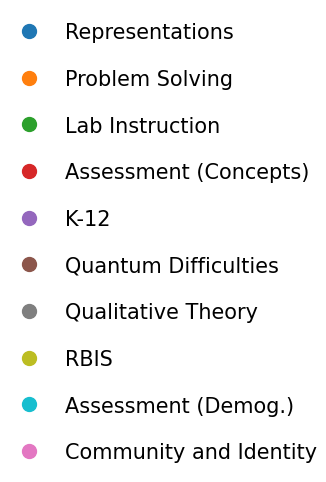

In [7]:
# Plot the colors for the categories
plt.figure(figsize=(0.5, 6))
for i, (key, value) in enumerate(category_NameColor_dict.items()):
    plt.scatter(0, 11-i, c=value, s=100, label=key)
    plt.text(0.1, 11-(i+0.175), key, fontsize=15)
plt.axis('off')
plt.show()

The variable "centroid_indices" will here be the indices of the most representative articles for the same 10 topics as in the LDA analysis.

<a class="anchor" id="three_c"></a> 
## 3.C. Deciding on distance metrics, scaling functions, and hyperparameter values
Next, we need to decide which combination of distance metric (Euclidean, Manhattan, or Cosine similarity), scaling function (power law or exponential), and hyperparameter value ($\alpha$) will give us the most similar topic scores to LDA.
 
To do so, we will do a gridsearch over each of these variables. That is to say, we will choose one distance metric, and compute topic scores using both scaling functions, at a variety of alpha values, and compute how similar the topic scores are to those assigned by LDA.

In order to measure the similarity between LDA and embeddings topic scores, we have chosen to use the metric of [Jensen-Shannon Divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (JS-divergence), a common metric in NLP for quantifying the differences between two distributions. In our case, the distributions are the topic scores for each paper, across all 10 topics, calculated by LDA and the embeddings model.

For two probability distributions $P$ and $Q$, JS-divergence is defined as:

$\large JS(P||Q)=\frac{1}{2}KL(P||\frac{(P+Q)}{2})+\frac{1}{2}KL(Q||\frac{(P+Q)}{2})$

Where $KL(P||Q)$ is the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), an asymmetric measure of difference between two distributions, defined as:

$\large KL(P||Q)=\sum_{x}P(x)\log(\frac{P(x)}{Q(x)})$

Here, a JS-divergence value of 0 indicates that the two distributions are identical, and increasing differences between the two distributions correspond to increasingly higher values.

In order to benchmark this deviation we will also calculate the JS-divergence between the LDA scores and two other sets of scores: one sampled from a uniform distribution, and the other sampled from randomly generated scores. This will give us a sense of how well the embeddings model is performing relative to completely random topic assignments or completely uniform topic assignments.

In [8]:
# new functions for calculating the KL divergence and JS divergence
import math as math

def kl_divergence(p, q):
    p = np.where(p == 0, 1e-10, p)
    q = np.where(q == 0, 1e-10, q)
    return np.sum(p * np.log2(p / q), axis = 1)


def js_divergence(p, q):
    m = 0.5*(p+q)    
    return 0.5*(kl_divergence(p, m) + kl_divergence(q, m))

In [9]:
# The uniform benchmark - Calculated by generating a matrix of 0.1
zero_p_one_matrix = np.zeros((1745,10)) + 0.1
zero_p_one_score_unrounded = np.sum(js_divergence(zero_p_one_matrix, LDA_scores))

print("Sum of JS divergence of uniform scores (aka 0.1 for each topic) against LDA scores:")
print(zero_p_one_score_unrounded)

Sum of JS divergence of uniform scores (aka 0.1 for each topic) against LDA scores:
581.9447693171344


In [10]:
# The Random benchmark - Calculated by generating random vectors
n = 2000 # Number of times we create random vectors
JS_random_unrounded = np.zeros(n) # Array to store the JS scores for each n-run

for i in range(n):
    # Generate random vectors and normalize them (read sum to 1)
    random_vector = np.random.rand(number_of_articles,10)
    random_vector = random_vector/np.sum(random_vector, axis=1)[:,None]
    
    # Loop over all articles and calculate the 
    # JS divergence between the random vector and the LDA scores:
    JS_random_unrounded[i]= np.sum(js_divergence(LDA_scores, random_vector))


print(f"Sum of JS divergence of randomly generated scores against LDA scores n = {n}:")
print("mean:", np.mean(JS_random_unrounded), "std:", np.std(JS_random_unrounded))

Sum of JS divergence of randomly generated scores against LDA scores n = 2000:
mean: 660.1169499213477 std: 3.5387802305661764


With these benchmarks established, we will now calculate the JS divergence for different combinations of distance metrics, scaling functions, and values of the hyperparameter $\alpha$. The plot that follows illustrates the different results and lets us find the optimal combination via the minimum JS-divergence value.

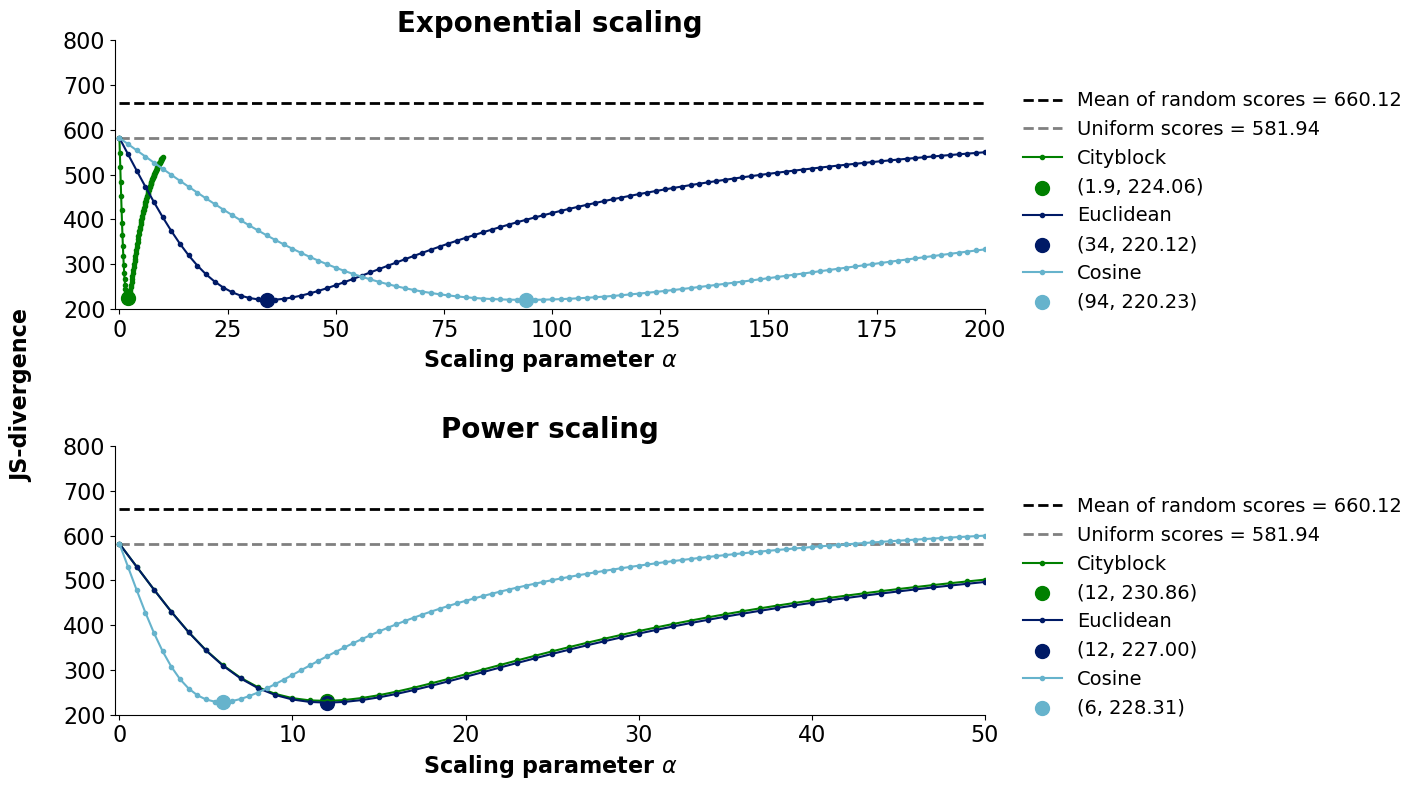

In [11]:
# Define the different scalings and metrics
scalings = ["exponential", "power"]
metrics = ["cityblock", "euclidean", "cosine"]

# Different alpha values for the different scalings and metrics as
# some scalings and metrics are more sensitive to alpha than others
alpha_list = [(np.linspace(0, 10, 101),         # Exponential + Manhatten 
               np.linspace(0, 200, 101),        # Exponential + Euclidean
               np.linspace(0, 200, 101)),       # Exponential + Cosine
            (np.linspace(0, 50, 51),            # Power + Manhatten
             np.linspace(0, 50, 51),            # Power + Euclidean
             np.linspace(0, 50, 101)),          # Power + Cosine
            ]

# Initialize the figure
fig, axs = plt.subplots(len(scalings), 1, figsize=(16,4*len(scalings)), sharey=True)

# Define the colors for the different metrics
color = plt.cm.ocean(np.linspace(0,0.8,len(metrics)))

# Loop over the different scalings
for i, scaling in enumerate(scalings):
    
    # Create a linspace for plotting the horizontal lines (y1 and y2)
    nr = 1000
    stop = alpha_list[i][2][-1]
    linspace = np.linspace(0, stop, nr)
    
    # The benchmark scores 
    y1 = JS_random_unrounded.mean() + np.zeros(nr) # + np.zeros(nr) to get the
    y2 = zero_p_one_score_unrounded + np.zeros(nr) # right shape for plotting
    
    #plotting y1 and y2 as horizontal lines
    axs[i].plot(linspace, y1, "--",
                color="black", linewidth=2,
                label=f"Mean of random scores = {y1[0]:.2f}")
    axs[i].plot(linspace, y2, "--",
                color="gray", linewidth=2,
                label=f"Uniform scores = {y2[0]:.2f}")
    
    
    # Loop over the different metrics
    for j, metric in enumerate(metrics):
        alpha = alpha_list[i][j]
        y = np.zeros(len(alpha))
        
        # Calculate the JS divergence for each alpha
        for k, alp in enumerate(alpha):
            # Calculate the embedding scores for each alpha, metric and scaling
            embedding_scores = embedding_score(embedding_matrix, alp, centroid_indices,
                                               metric, scaling, rounding=False)
           
            # Assigning the sum of js-divergence for every article to the y-array
            y[k] = np.sum(js_divergence(embedding_scores, LDA_scores))
        
        
        # Plot the JS divergence over alpha for each metric and scaling
        axs[i].plot(alpha, y , "-o", label=metric.capitalize(), color=color[j], ms=3)
        
        # Plotting the minimum of each curve:
        min_index = np.nanargmin(y)
        min_alpha = alpha[min_index]
        min_y = y[min_index]

        # Just for formatting the legend of the minimum
        label_format = "({:.0f}, {:.2f})" if min_alpha % 1 == 0 else "({:.1f}, {:.2f})"
        label = label_format.format(min_alpha, min_y)

        # Plotting the minimum as a scatter point
        axs[i].scatter(min_alpha, min_y, label=label, color=color[j], marker="o", s=100)

    # Watch out for the y-axis limits as they are static
    axs[i].set_ylim(200, 800)
    # Formatting the plots
    axs[i].set_xlabel(r"Scaling parameter $\alpha$", fontsize=16, fontweight='bold')
    axs[i].set_title(f"{scaling.capitalize()} scaling", fontsize=20, fontweight='bold')
    axs[i].spines[['right', "top"]].set_visible(False)
    axs[i].set_xlim(-0.005*stop,stop)
    axs[i].tick_params(axis='both', which='major', labelsize=16)
    axs[i].legend(fontsize=14, loc="right", frameon=False, bbox_to_anchor=(1.5, 0.4))

fig.supylabel(r"JS-divergence", fontsize=16, x=0, y=0.5, fontweight='bold')
fig.tight_layout(w_pad=3, h_pad=3)

From these graphs we find that the we minimize the JS-divergence with the LDA topic scores using either a Cosine similarity or Euclidean metric (they have 99.95% overlap in score) and exponential scaling function, with alpha at 94. However, even the global differences are small, since only around 10 bits differ between the global minima of each combination of hyperparameters. However, theoretically we find that Cosine similarity metric makes sense, since when dealing with high-dimensional data [it is often preferable to include the "angle" of vectors](https://www.maartengrootendorst.com/blog/distances/) (which Cosine similarity does), rather than pure measures of distance.

We will now use these results to calculate the embedding score for every article in our dataset.

In [12]:
# Set the parameters for the embedding scores to use in for the analysis. We set alpha to 94.
alpha = 94
scaling = "exponential"
metric = "cosine"

# Calculate the embedding scores 
embedding_scores_10 = embedding_score(embedding_matrix, alpha, centroid_indices,
                                      metric, scaling, rounding=False)

# Add the embedding scores to the DataFrame in the same order as the LDA scores
for i, category in enumerate(LDA_category_names):
    df_embeddings[str(category)] = embedding_scores_10[:,i]

<a class="anchor" id="three_d"></a> 
## 3.D. Investigating the JS-divergence distribution among articles

As a check on our approach, let's investigate how the JS-divergence is distributed amongst the articles. Remember that when we calculated differences between LDA and embeddings, we simply summed the JS-divergence over all articles. However, this doesn't tell us anything about how specific articles might have contributed to this aggregate score. Are there certain articles that the two models had significant difficulty classifying, or was the divergence approximately equally distributed among all articles?

JS divergence between LDA and embedding scores with alpha = 94 :
Mean JS divergence: 0.12620878151814108
Std JS divergence: 0.07873231594232404


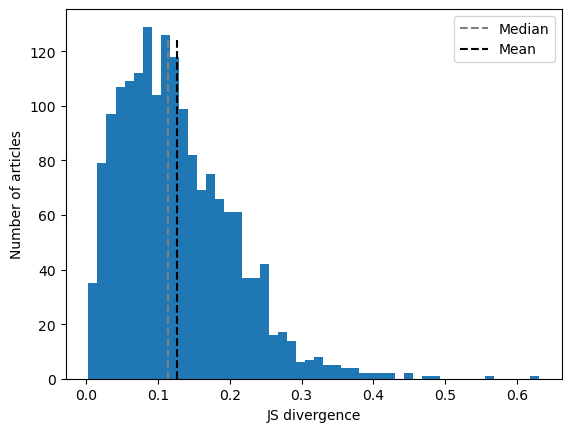

In [13]:
# Array to store the JS divergence
JS_divergence_array = js_divergence(embedding_scores_10, LDA_scores)


print("JS divergence between LDA and embedding scores with alpha =", alpha, ":")
print("Mean JS divergence:", np.mean(JS_divergence_array))
print("Std JS divergence:", np.std(JS_divergence_array))

# Plotting the distribution of the JS divergence
plt.hist(JS_divergence_array, bins=50)
#median
plt.plot([np.median(JS_divergence_array), np.median(JS_divergence_array)], [0, 125], 
         "--", color="gray", label="Median")
#mean
plt.plot([np.mean(JS_divergence_array), np.mean(JS_divergence_array)], [0, 125],
         "--", color="black", label="Mean")
plt.xlabel("JS divergence")
plt.ylabel("Number of articles")
plt.legend()
plt.show()

In [14]:
# Calculate the sum of the absolute difference between the LDA scores and the embedding scores
absolute_difference = np.sum(np.abs(LDA_scores - embedding_scores_10))
print(f"Sum of the absolute difference between the LDA scores and the embedding scores: {absolute_difference}")

Sum of the absolute difference between the LDA scores and the embedding scores: 1061.4945873997003


Here, we see that the distribution has a significant number of articles around 0 divergence, a peak around 0.1, and a long (but shallow) tail. This tells us that the models were able to agree on many articles, had some disagreement on most, and had a few with high levels of disagreement (JS-divergence > 0.3). We will investigate these cases in detail later on.

<a class="anchor" id="three_e"></a>
## 3.E. Investigating LDA-based embeddings score distribution

LDA is a mixed-topic model, so it does not classify articles into single category but rather provides a percent distribution among categories (Odden et al, 2020)[[2]](#ref3). Ideally, our embeddings-based approach will do the same, at least for the present analysis. So, next we want to investigate the heterogeneity ("mixedness") of our score distributions. To do this we create histograms of how the scores are distributed, both for the LDA scores and the embedding scores. We will bin the "primary topic scores", meaning the highest scores for each article, into 50 bins, and do the same for the secondary and tertiary topics, then examine the count of articles that had different percents of primary/secondary/tertiary topics to see how mixed the topic scores were from each model. If models assigned a variety of scores (i.e., they are fairly mixed), this will appear as varying distributions. We will also be able to see how LDA and embeddings compared in their general level of topic scoring.

LDA
mean of primary topic score: 0.5326700534639522
std of primary topic score: 0.17403011417375733


Embedding scores
mean of primary topic score: 0.47012274306182783
std of primary topic score: 0.19991199854967276




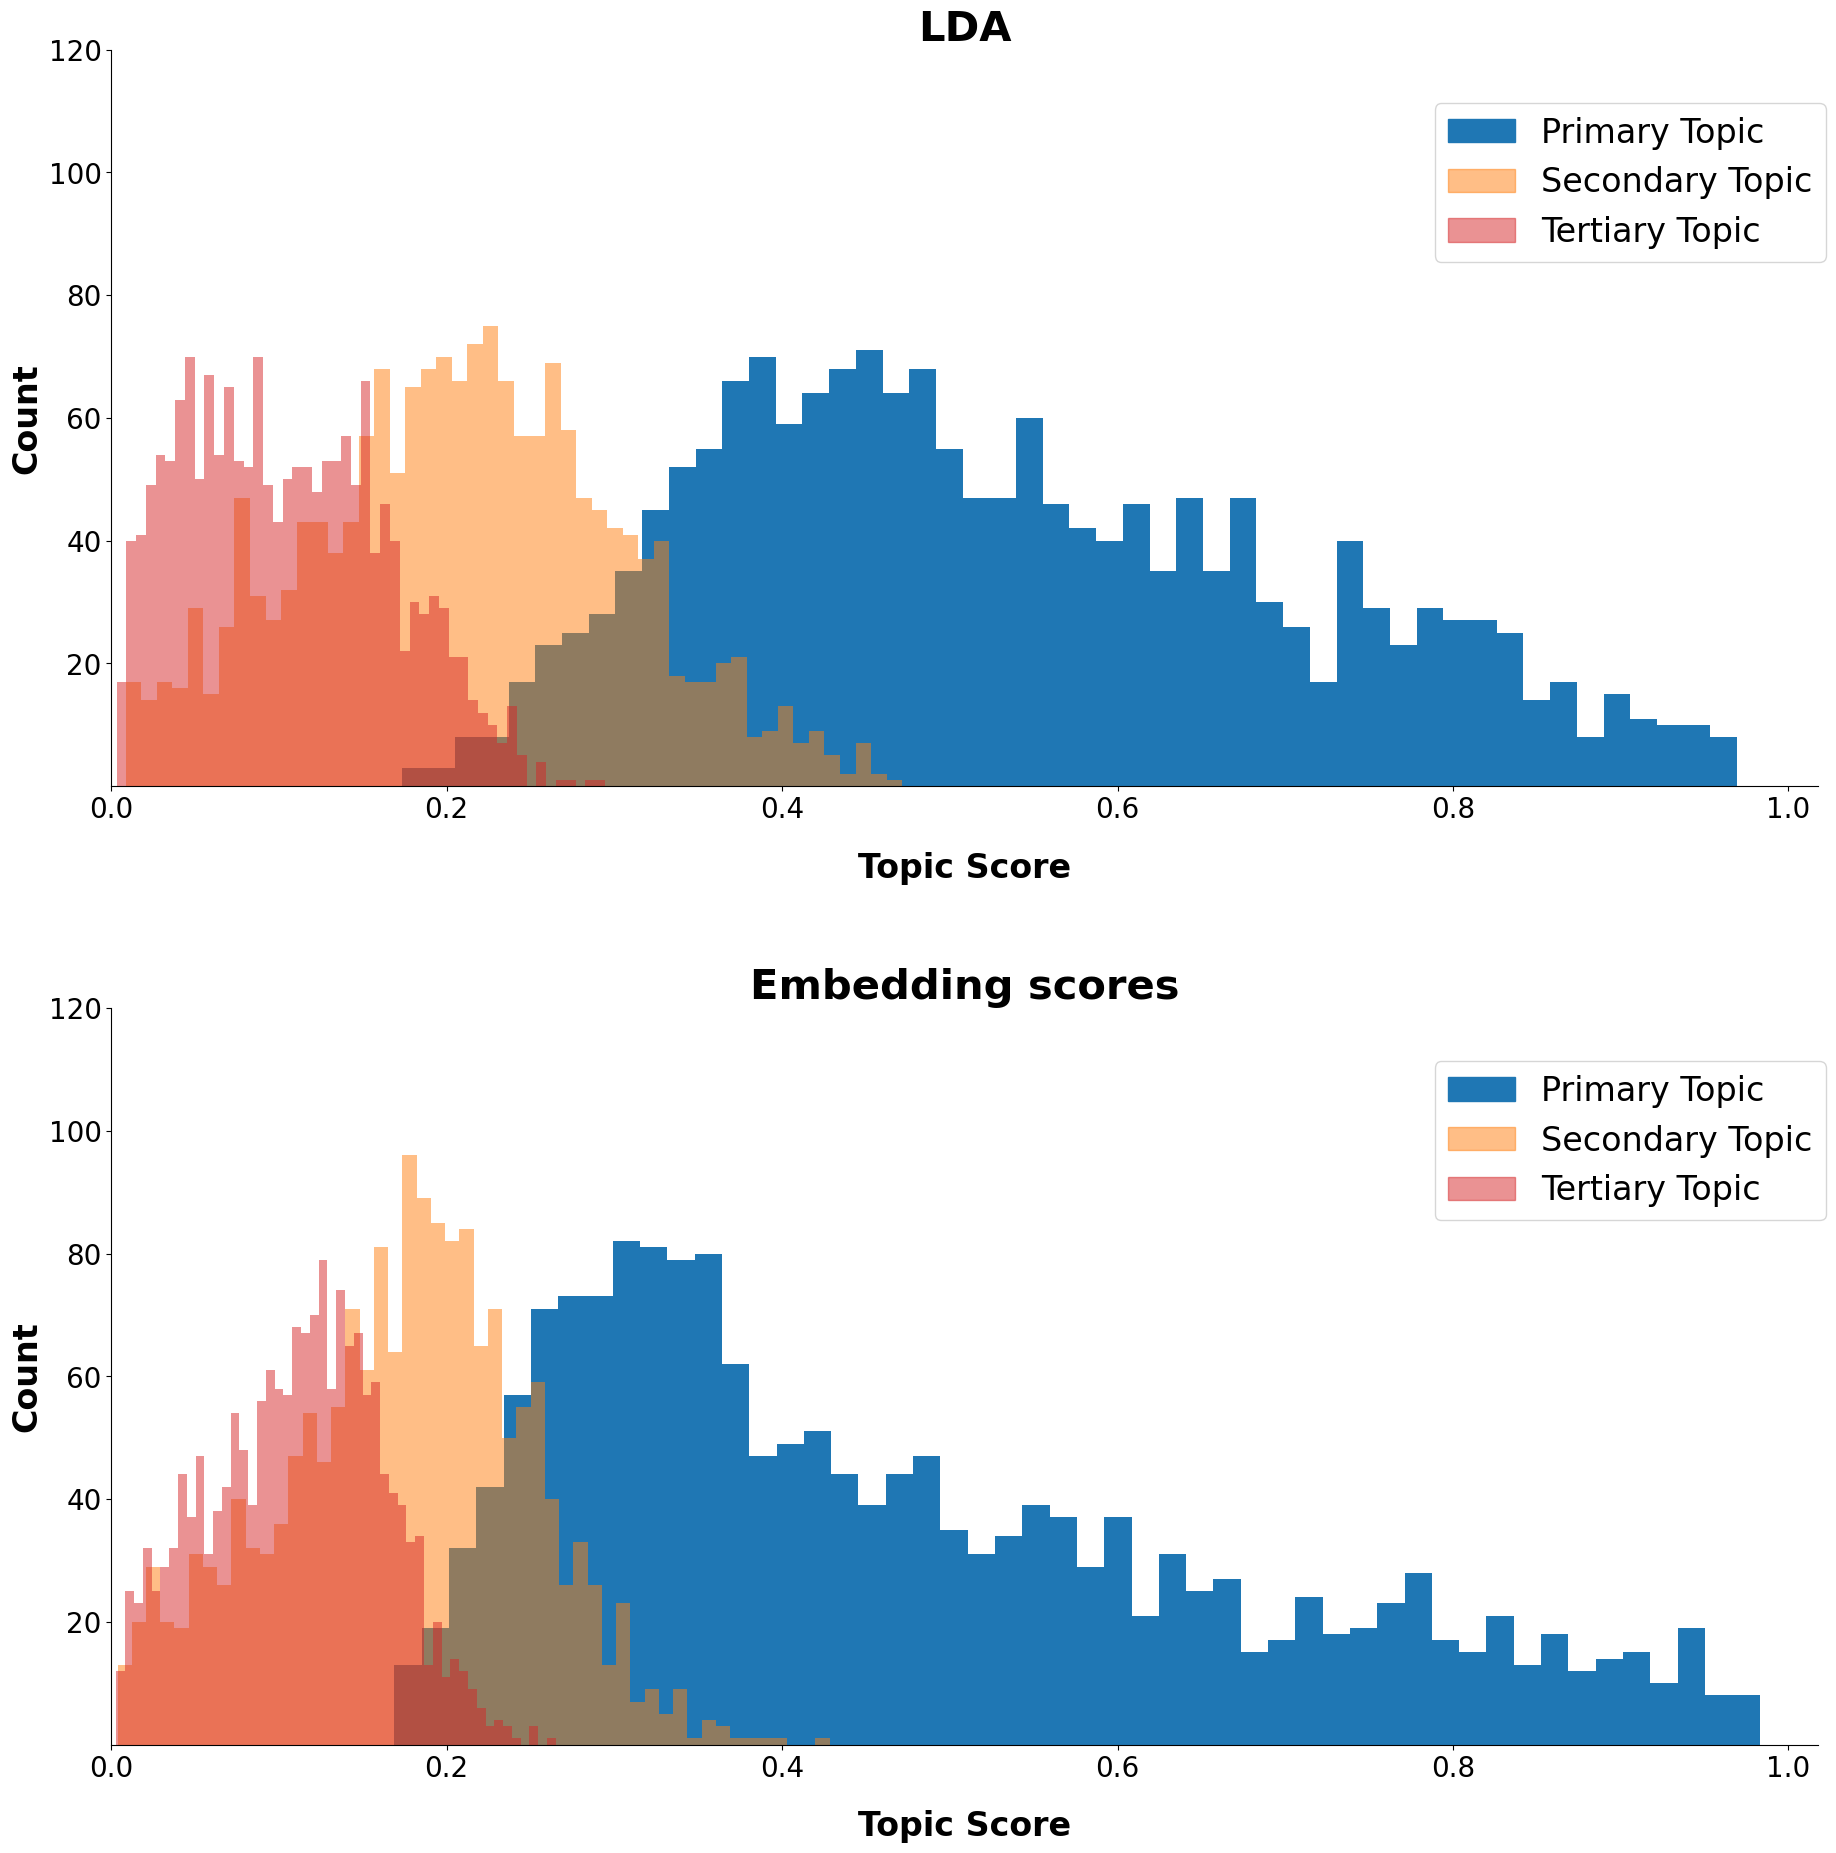

In [15]:
# Choosing which scores we want to plot, and also given them a title
scores_title = {"LDA": LDA_scores, "Embedding scores": embedding_scores_10}

# Initialize the figure
fig, axs = plt.subplots(len(scores_title), 1, figsize=(20,20), sharex=True, sharey=True)


colors = ["C0", "C1", "C3"] #primary, secondary, tertiary colors
labels=["Primary Topic", "Secondary Topic", "Tertiary Topic"]

# Create handles for the legend
handles = [mpatches.Patch(color=colors[0], label=labels[0]),
           mpatches.Patch(color=colors[1], alpha=0.5, label=labels[1]),
           mpatches.Patch(color=colors[2], alpha=0.5, label=labels[2])]

# Loop over the different scores
for i, title in enumerate(scores_title):
    
    # Calculate the primary, secondary and tertiary topic scores
    primary_topic_score = np.max(scores_title[title], axis=1)
    secondary_topic_score = np.partition(scores_title[title], -2, axis=1)[:, -2]
    tertiary_topic_score = np.partition(scores_title[title], -3, axis=1)[:, -3]
    
    # Print the mean and std of the primary topic score
    print(title)
    print("mean of primary topic score:", np.mean(primary_topic_score))
    print("std of primary topic score:", np.std(primary_topic_score))
    print("\n")
    
    # Plotting the histograms of the scores
    axs[i].hist(primary_topic_score, bins=50, color=colors[0])
    axs[i].hist(secondary_topic_score, bins=50, alpha=0.5, color=colors[1])
    axs[i].hist(tertiary_topic_score, bins=50, alpha=0.5, color=colors[2])
    
    # Formatting the plots
    axs[i].set_title(title, fontsize=30, fontweight='bold')
    axs[i].set_xlabel("Topic Score", fontsize=24, labelpad=20, fontweight='bold')
    axs[i].set_ylabel("Count", fontsize=24, fontweight='bold')
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].tick_params(which='both', bottom=True, top=False, labelbottom=True, labelsize=20)
    axs[i].set_xlim(left=0)
    axs[i].legend(handles=handles, labels=labels, fontsize=24,
                  loc='upper center', bbox_to_anchor=(0.89, 0.95))

# Removing the y tick at 0, since sharey=True, it will be removed for both subplots
axs[0].set_yticks(axs[0].get_yticks()[1:])

fig.tight_layout(pad=6.0)
plt.show()

It is clear from this that both models are mixed models (few articles have a score of 1 as their highest score). The distribution of embedding scores seem to be somewhat similar to the LDA scores, although a bit more left heavy (i.e., it often assigned primary topic scores of around 0.3, meaning that papers recieved a mix of different scores). 

The $\alpha$ scaling parameter can be used to adjust this skewness. For example an extremely high value of $\alpha$ would push primary topic scores towards 1. If you would like to check this, you can adjust the alpha value above (at the end of section 3.C.) and regenerate the plot.

<a class="anchor" id="three_f"></a>
## 3.F. Checking correlation between LDA and embeddings scores using Kendall's tau

Another measure of similarity between the two sets of scores is the correlation between scores for particular papers. To calculate this, we cannot use Pearson's correlation coefficient, since the data is not normally distributed; so, we will use a ranked correlation approach, i.e, Spearman's correlation coefficient or Kendall's Tau. Spearman's correlation coefficient does not do well when there are many ties in the data (which is the case here, given the frequent topic scores of 0 for many articles), so we will be using Kendall's $\tau$. 

Kendall's $\tau$ is a measure of the correlation of two variables, in our case the LDA topic score and the embedding score. If they have matching scores for an article, then we have what is called a concordant pair. Diverging scores lead to a discordant pair. Kendall's tau calculates a number based of the amount of concordant and discordant pairs, where the highest is 1 (meaning equal distributions of concordant/discordant pairs) and lowest is -1 (meaning opposite distributions). The mathematical definition of Kendall's tau is:

$\large \tau = \frac{n_c - n_d}{\sqrt{(n_0 - n_1)(n_0 - n_2)}}$

We will also generate scatter plots of topic scores by LDA and embeddings, as a check to see if these results make sense.

Representations: r = 0.56, p = 3.61961e-272
Problem Solving: r = 0.43, p = 1.11613e-162
Lab Instruction: r = 0.49, p = 1.59773e-208
Assessment (Concepts): r = 0.48, p = 7.34873e-200
K-12: r = 0.48, p = 6.88694e-202
Quantum Difficulties: r = 0.42, p = 3.09857e-154
Qualitative Theory: r = 0.60, p = 1.87196e-306
RBIS: r = 0.52, p = 2.42002e-230
Assessment (Demog.): r = 0.52, p = 3.99679e-234
Community and Identity: r = 0.65, p = 0


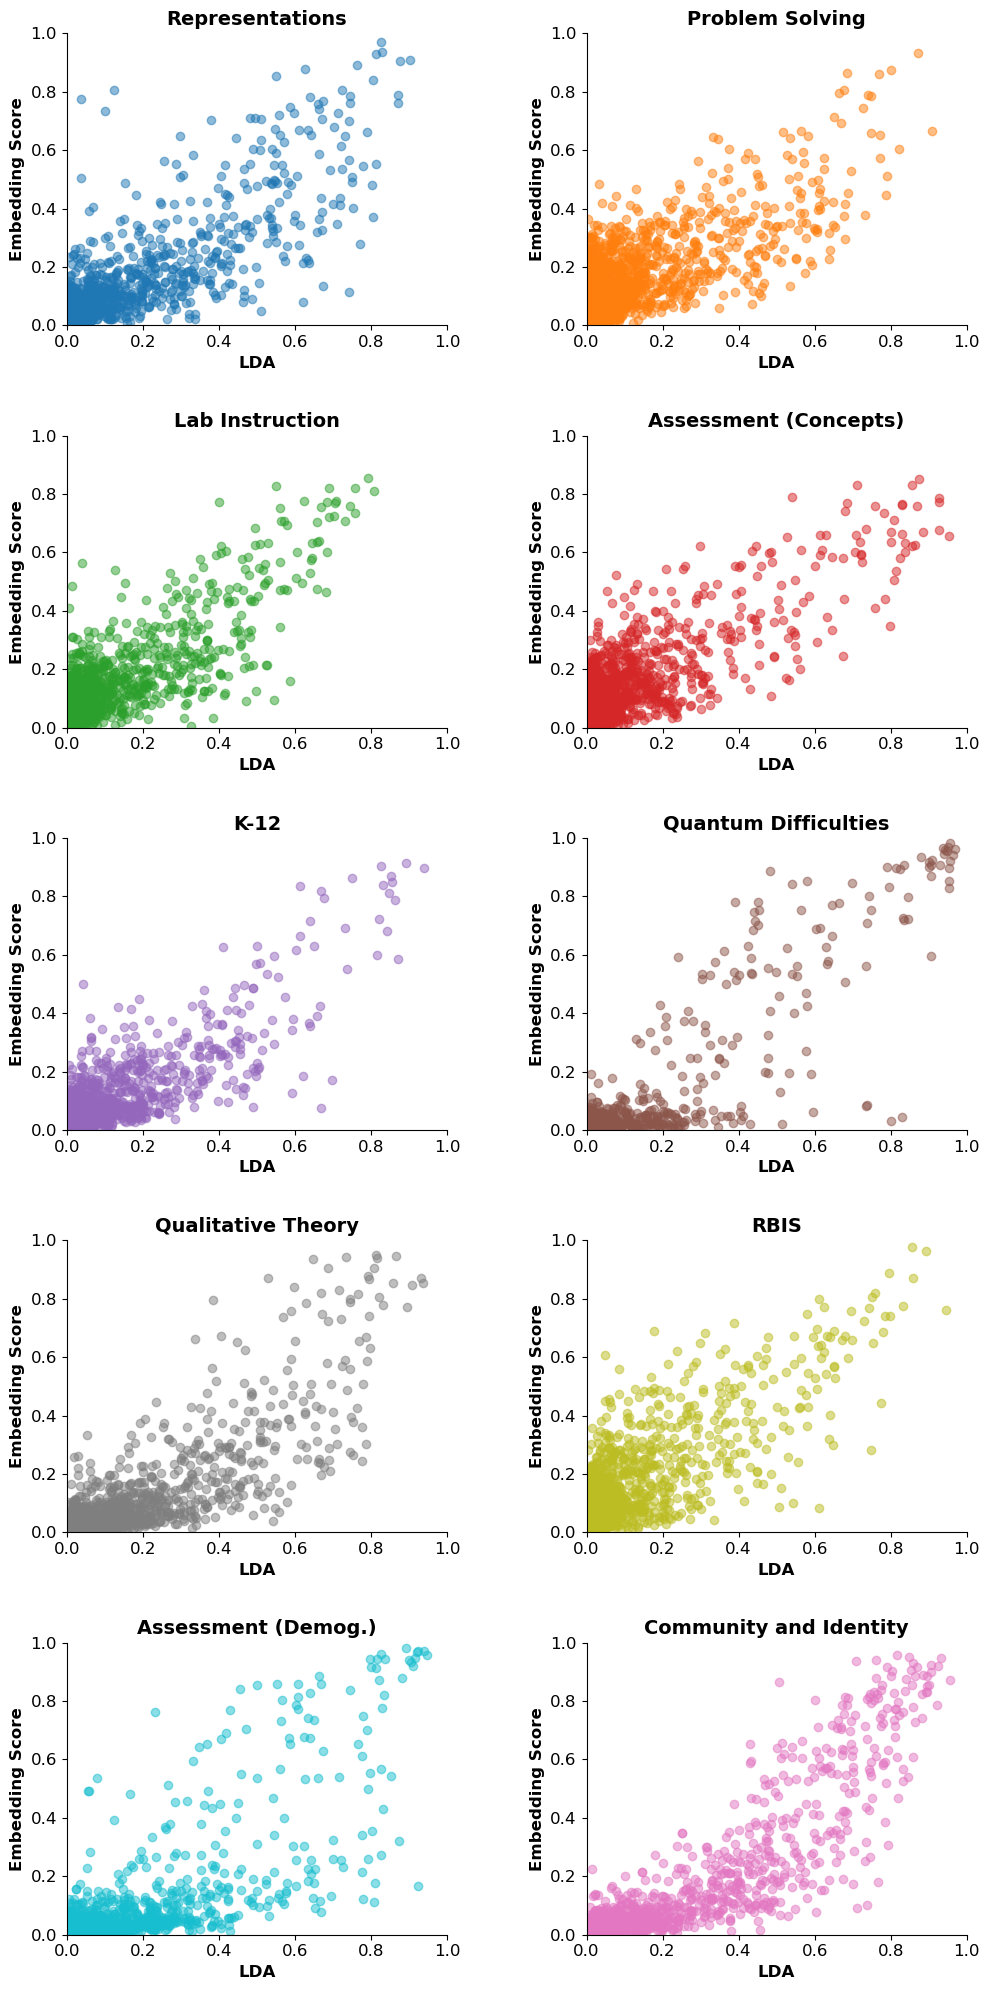

In [16]:
# Kendelltau correlation coefficient
from scipy.stats import kendalltau, pearsonr, spearmanr

fig, axs = plt.subplots(5, 2, figsize=(10,20))
axs = axs.flatten()

for i, (name, color) in enumerate(category_NameColor_dict.items()):
    # Get the embedding scores and LDA scores for category i
    x = LDA_scores[:, i]
    y = embedding_scores_10[:, i]
    
    # Here you can change to either pearsonr, spearmanr or kendalltau
    r, p = kendalltau(x, y)
    print(f"{name}: r = {r:.2f}, p = {p:g}")
    # r is the correlation coefficient
    # p is the p-value
    
    # Plot the scatter plot and adjust a bunch of stuff for prettiness
    axs[i].scatter(x, y, alpha=0.5, color=color)
    #axs[i].text(0.05, 0.9, f"r = {r:.2f}", transform=axs[i].transAxes, fontsize=8)
    axs[i].set_xlabel("LDA", fontsize=12, fontweight="bold")
    axs[i].set_ylabel("Embedding Score", fontsize=12, fontweight="bold")
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(0, 1)
    axs[i].set_title(name, fontsize=14, fontweight='bold')
    
fig.tight_layout(w_pad=5.0, h_pad=3.0)
plt.show()

From the scatter plot, we see that in some cases the embeddings model gave very low scores wile LDA gave somewhat higher scores: in these cases, the data appears smeared across the x-axis (for example, Community and Identity, Assessment (Demographics), Quantum Difficulties, and Qualitative Theory). In other cases, this trend is reversed: in these cases, data appears smeared across the y-axis. Kendall's Tau values vary from 0.42 (Quantum Difficulties) to 0.65 (Community and Identity); however, correlation coefficients calculated by Kendall's Tau tend to be somewhat lower than those calculated by Pearson or Spearman. We have found [several](https://journals.sagepub.com/doi/10.1177/0013164493053001007) [sources](https://blogs.sas.com/content/iml/2023/04/05/interpret-spearman-kendall-corr.html) that offer conversions between the different cutoff values: these sources suggest that Tau values of 0.26-0.49 are moderate, and 0.49-0.71 are strong. Based on these benchmarks, we would interpret the correlation (agreement) between LDA and our embeddings model as strong for Representations, Lab Instruction, Qualitative Theory, RBIS, Assessment (Demog.), and Community and Identity. All other correlations would be rated as moderate; however, Assessment (Concepts) and K-12 are right under the cutoff (0.48).

Taking a step back, if we consider the two models as essentially two "raters" (in a qualitative analysis sense), this allows us to establish a kind of inter-rater reliability. It suggests that the two models are able to strongly agree on their scoring of 6/10 topics, and moderately agree on their scoring of the remaining 4/10. Differences likely stem from the fact that LDA is focused on vocabulary use, while the embeddings model is focused on semantic meaning of the text.

<a class="anchor" id="three_g"></a> 
## 3.G. Face validity check: reclassified articles

Another way of evaluating differences between the models is looking at how individual papers have been reclassified. To investigate this, we created a heatmap plot of topic scores for particular articles, which allows us to compare the topic-by-topic difference between embeddings and LDA scores. More specifically we pull out a representative sample of reclassified papers by plotting topic scores for the papers that have a JS-divergence closest to the mean.

To examine the biggest differences between the models, we also pull out the five papers with the highest JS-divergence (that is, the five paper on which LDA and our method disagreed the most). This allows us to see if there are patterns in the cases in which the two models had high levels of disagreement.

In [17]:
# Function for creating a heatmap of the embedding scores, Its heavily modified
# to plot our exact data. 
def plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap):
    """This function is for plotting heatmaps for 5 articles and their corresponding
    scores. One can either pass in just embedding scores, or both LDA and embedding scores.
    The function will then plot the heatmaps for the scores, and also calculate the JS divergence
    between the two scores if both are passed in.

    Args:
        fig (matplotlib fig): The figure to plot the heatmaps on
        axs (matplotlib axs): The axs to plot the heatmaps on, len 5
        scores_list (list): A list of the scores to plot
        title_list (list): Title for each of the subplots
        legend_patches (matplotlib legend): Legend to plot
        cmap (matplotlib cmap): colors for heatmap

    Returns:
        _type_: _description_
    """
    assert len(scores_list) == len(title_list) == len(axs)

    # For naming the subplots
    alphabet = list(string.ascii_lowercase)
    
    # Creating text on left side of the heatmap
    y_tl = False
    if len(scores_list[0]) == 2:
        y_tl = ["LDA",'EMB']

    for scores, title, ax, letter in zip(scores_list, title_list, axs, alphabet):
        # Plot the heatmap
        gx = sns.heatmap(scores, cmap=cmap, annot=True, yticklabels=y_tl,
                         xticklabels=range(1,len(scores[0])+1), vmin=0, vmax=1,
                         ax=ax, cbar=False, fmt='.2f')
        
        # Formatting the ticks
        gx.set_yticklabels(gx.get_yticklabels(), fontsize=9)
        
        # Add the JS divergence to the right of each heatmap if both LDA and embedding scores are passed in
        if len(scores) == 2:
            JS_div = js_divergence(scores[0].reshape(1, -1), scores[1].reshape(1, -1))
            ax.text(10.1, 1.5, f'JS: {JS_div[0]:.2f}',
                    fontsize=9, rotation=-90, fontweight='bold')
            
        ax.set_title(title, fontweight='bold', fontsize=10)
        ax.text(-0.3, -0.2, f"({letter})", fontsize=11, fontweight='bold')
        
    # Create a colorbar
    # cbar_ax = fig.add_axes([1.1, 0.05, 0.075, 0.64])
    # cbar = fig.colorbar(gx.collections[0], cax=cbar_ax)
    # cbar.outline.set_visible(False)
    # cbar.ax.tick_params(labelsize=8)
    # cbar.set_label('', rotation=270, fontsize=8, labelpad=10)
    
    # Create fig legend
    fig.legend(handles=legend_patches, bbox_to_anchor=(1, 0),
               frameon = False, prop={'size': 10, 'weight':'bold'}, ncols=4)
    
    fig.tight_layout(w_pad=2, h_pad=2)
    
    return fig, axs

In [18]:
# Create color map for heatmap plots
colors = [(0.95, 0.95, 1), (0.5, 0.75, 1), (0.4, 0.5, 0.9),
            (0.3, 0.4, 0.8), (0.2, 0.3, 0.7), (0.1, 0.15, 0.5)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)
# Legend patches is the categories for the LDA scores
legend_patches = [mpatches.Patch(color='white', label=(f'{i+1}: {category}')) for i, category in enumerate(LDA_category_names)]

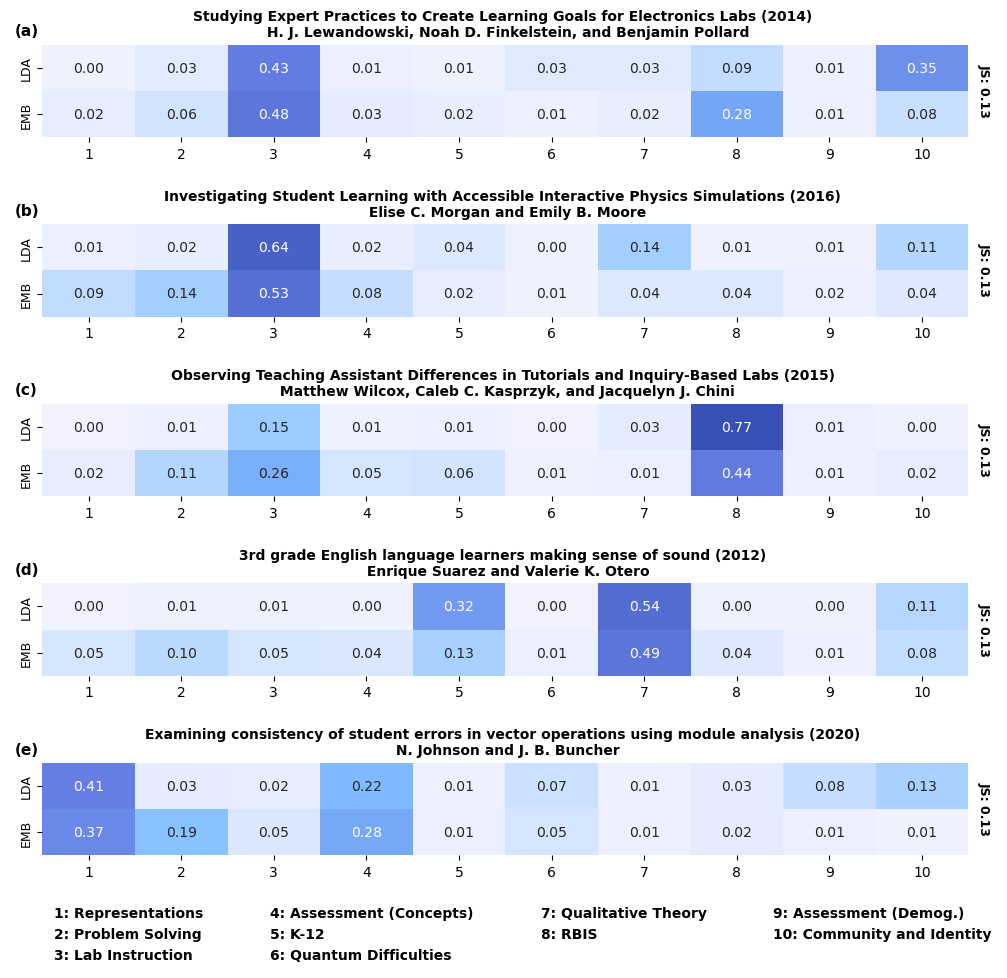

In [19]:
# Create the inputs for the plot_heatmap function
scores_list = []
title_list = []

# List of indices of the articles that are closest to the mean
heatmap_indices = np.abs(JS_divergence_array - np.mean(JS_divergence_array)).argsort()[:5]

# Filling in the scores_list and title_list, for the plot_heatmap function
for i, index in enumerate(heatmap_indices):
    scores_list.append([LDA_scores[index, :], embedding_scores_10[index, :]])
    title_list.append(f'{df_LDA["title"][index]} ({df_LDA["year"][index]}) \n {df_LDA["authors"][index]}')

# Using the heatmap function to plot the heatmap
fig, axs = plt.subplots(5,1, figsize=(10, 9))
fig, axs = plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap)
plt.show()

Here, we have plotted articles with approximately mean JS-divergence. It's clear that there's a lot of overlap,e specially in primary topic categories; however, the two models often diverge on the exact percent of primary topic score, and/or assign different secondary or tertiary topic scores.

The differences are unpacked further in the companion article, which goes into detail on the reasons we might be seeing this disagreement on specific articles.

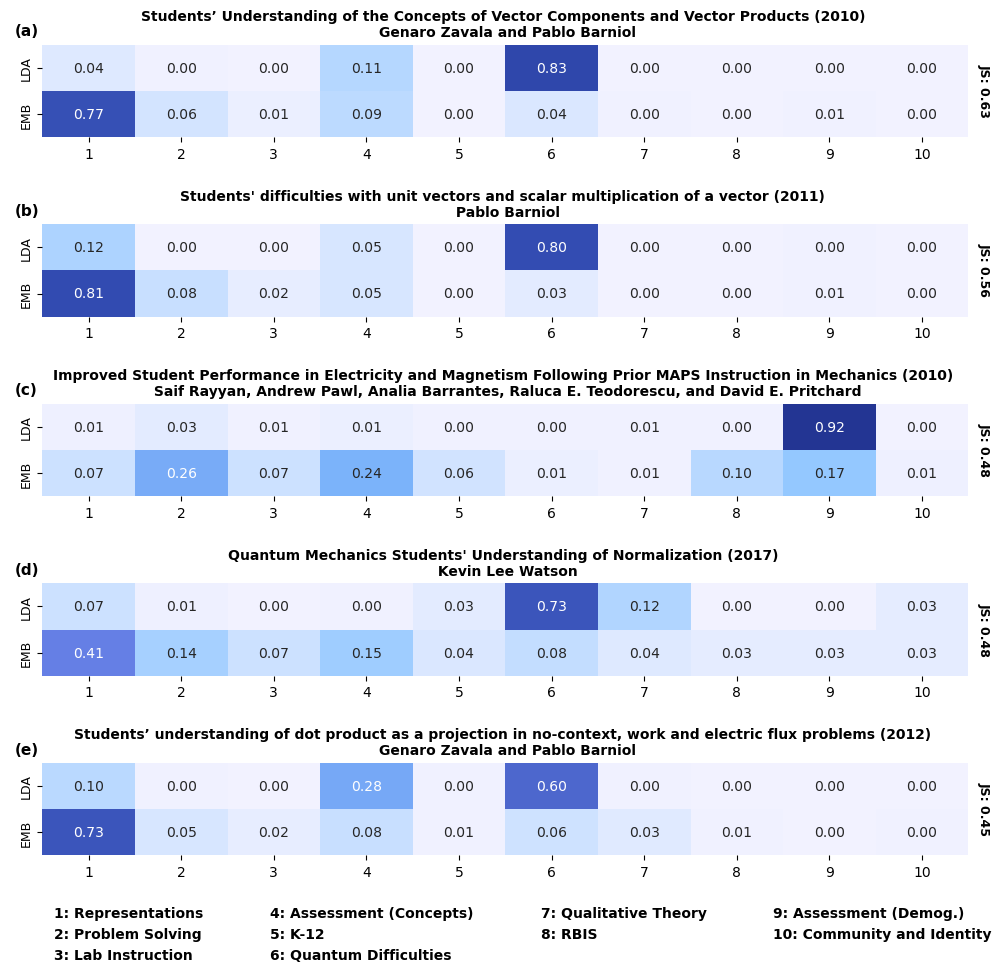

In [20]:
# Take the JS divergence array and argsort it to get the indices of the sorted array
# List of five articles with the highest JS divergence
heatmap_indices = np.argsort(JS_divergence_array)[-5:][::-1] # [::-1] is to flip the lis

# Create the inputs for the plot_heatmap function
scores_list = []
title_list = []

# Filling in the scores_list and title_list, for the plot_heatmap function
for i, index in enumerate(heatmap_indices):
    scores_list.append([LDA_scores[index, :], embedding_scores_10[index, :]])
    title_list.append(f'{df_LDA["title"][index]} ({df_LDA["year"][index]}) \n {df_LDA["authors"][index]}')

# Use the heatmap function to plot the heatmap
fig, axs = plt.subplots(5,1, figsize=(10, 9))
fig, axs = plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap)

Here, we plot the papers with highest JS-divergence. We see two general patterns: articles where the two models assigned very different primary topic scores (often Quantum Difficulties by LDA and Representations by embeddings), and cases in which LDA assigned a high topic score and the embeddings model smeared out its assignment over several categories. We unpack these differences in detail as well in the companion article.

<a class="anchor" id="three_h"></a> 
## 3.H. Plotting topic prevalence as a function of time
Next, we want to examine how the two models analyzed the development of topic prevalence as a function of time. To do so, we will create stacked area plots of aggregate topic scores of all articles published each year, normalized so that they equal 100% (which removes the effects of varying levels of publication each year). This plot can be thought of as answering the question "how much of each topic did we see in the publications every year" and lets us see if certain topics increased or decreased in the literature over time.

First, we create a general plotting function for stacked making the stacked area plots, which we will use again in our second analysis later. The function takes several arguments: the first is a list of years that go on the x-axis of the plot. The second argument is a matrix of the data that is plotted. We also have the category names and the color scheme as arguments. The function then plots the data as a stacked plot and assigns the right category name in the legend to the corresponding data in the plot. There are also a plethora of cosmetic adjustments to make the plot look nice.

In [21]:
def stacked_plot(x_data, y_data_matrix, name_list, colors):
    """Function for plotting a stacked plot of y data vs x data,
        with the labels in name_list and the colors in colors.

    Args:
        x_data (np.ndarray):  (shape: (n, )) 
        y_data_matrix (np.ndarray): (shape: (m, n))
        name_list (list): length m
        colors (list): length m
    """
    # Check that dimensions are correct
    assert len(name_list) == len(colors) == y_data_matrix.shape[0]
    assert y_data_matrix.shape[1] == len(x_data)
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(30, 14))              
      
    # Plotting stackplot with labels and using the pastel color palette
    ax.stackplot(x_data, y_data_matrix, baseline='zero', alpha=1,
                    labels=name_list, colors=colors)
    
    # Create a legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              fontsize=30, frameon=False, ncol=1, reverse=True)

    # Creating the x-axis ticks
    # Assuming 'x_data' is sorted and includes all x_data in the range
    tick_x_data = [year for i, year in enumerate(x_data) if i % 2 == 0]  # This will select every 4th year
    # Ensure the first and last x_data are included on the x-axis, regardless of the interval
    if tick_x_data[0] != x_data[0]:
        tick_x_data.insert(0, x_data[0])
    if tick_x_data[-1] != x_data[-1]:
        tick_x_data.append(x_data[-1])

    # Configure axis limits, labels and ticks
    ax.set_xlim([x_data[0], x_data[-1]])
    ax.set_xlabel('Year', fontsize=35, fontweight='bold', y=-0.2)
    ax.set_xticks(tick_x_data)
    
    ax.set_ylim(top=1)
    ax.set_ylabel('Normalized Topic Prevelance', fontsize=35, fontweight='bold')
    ax.set_yticks(ax.get_yticks()[1:])
    ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
    
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.spines[['right', 'top']].set_visible(False) # Remove the top and right spines
    
    fig.tight_layout()

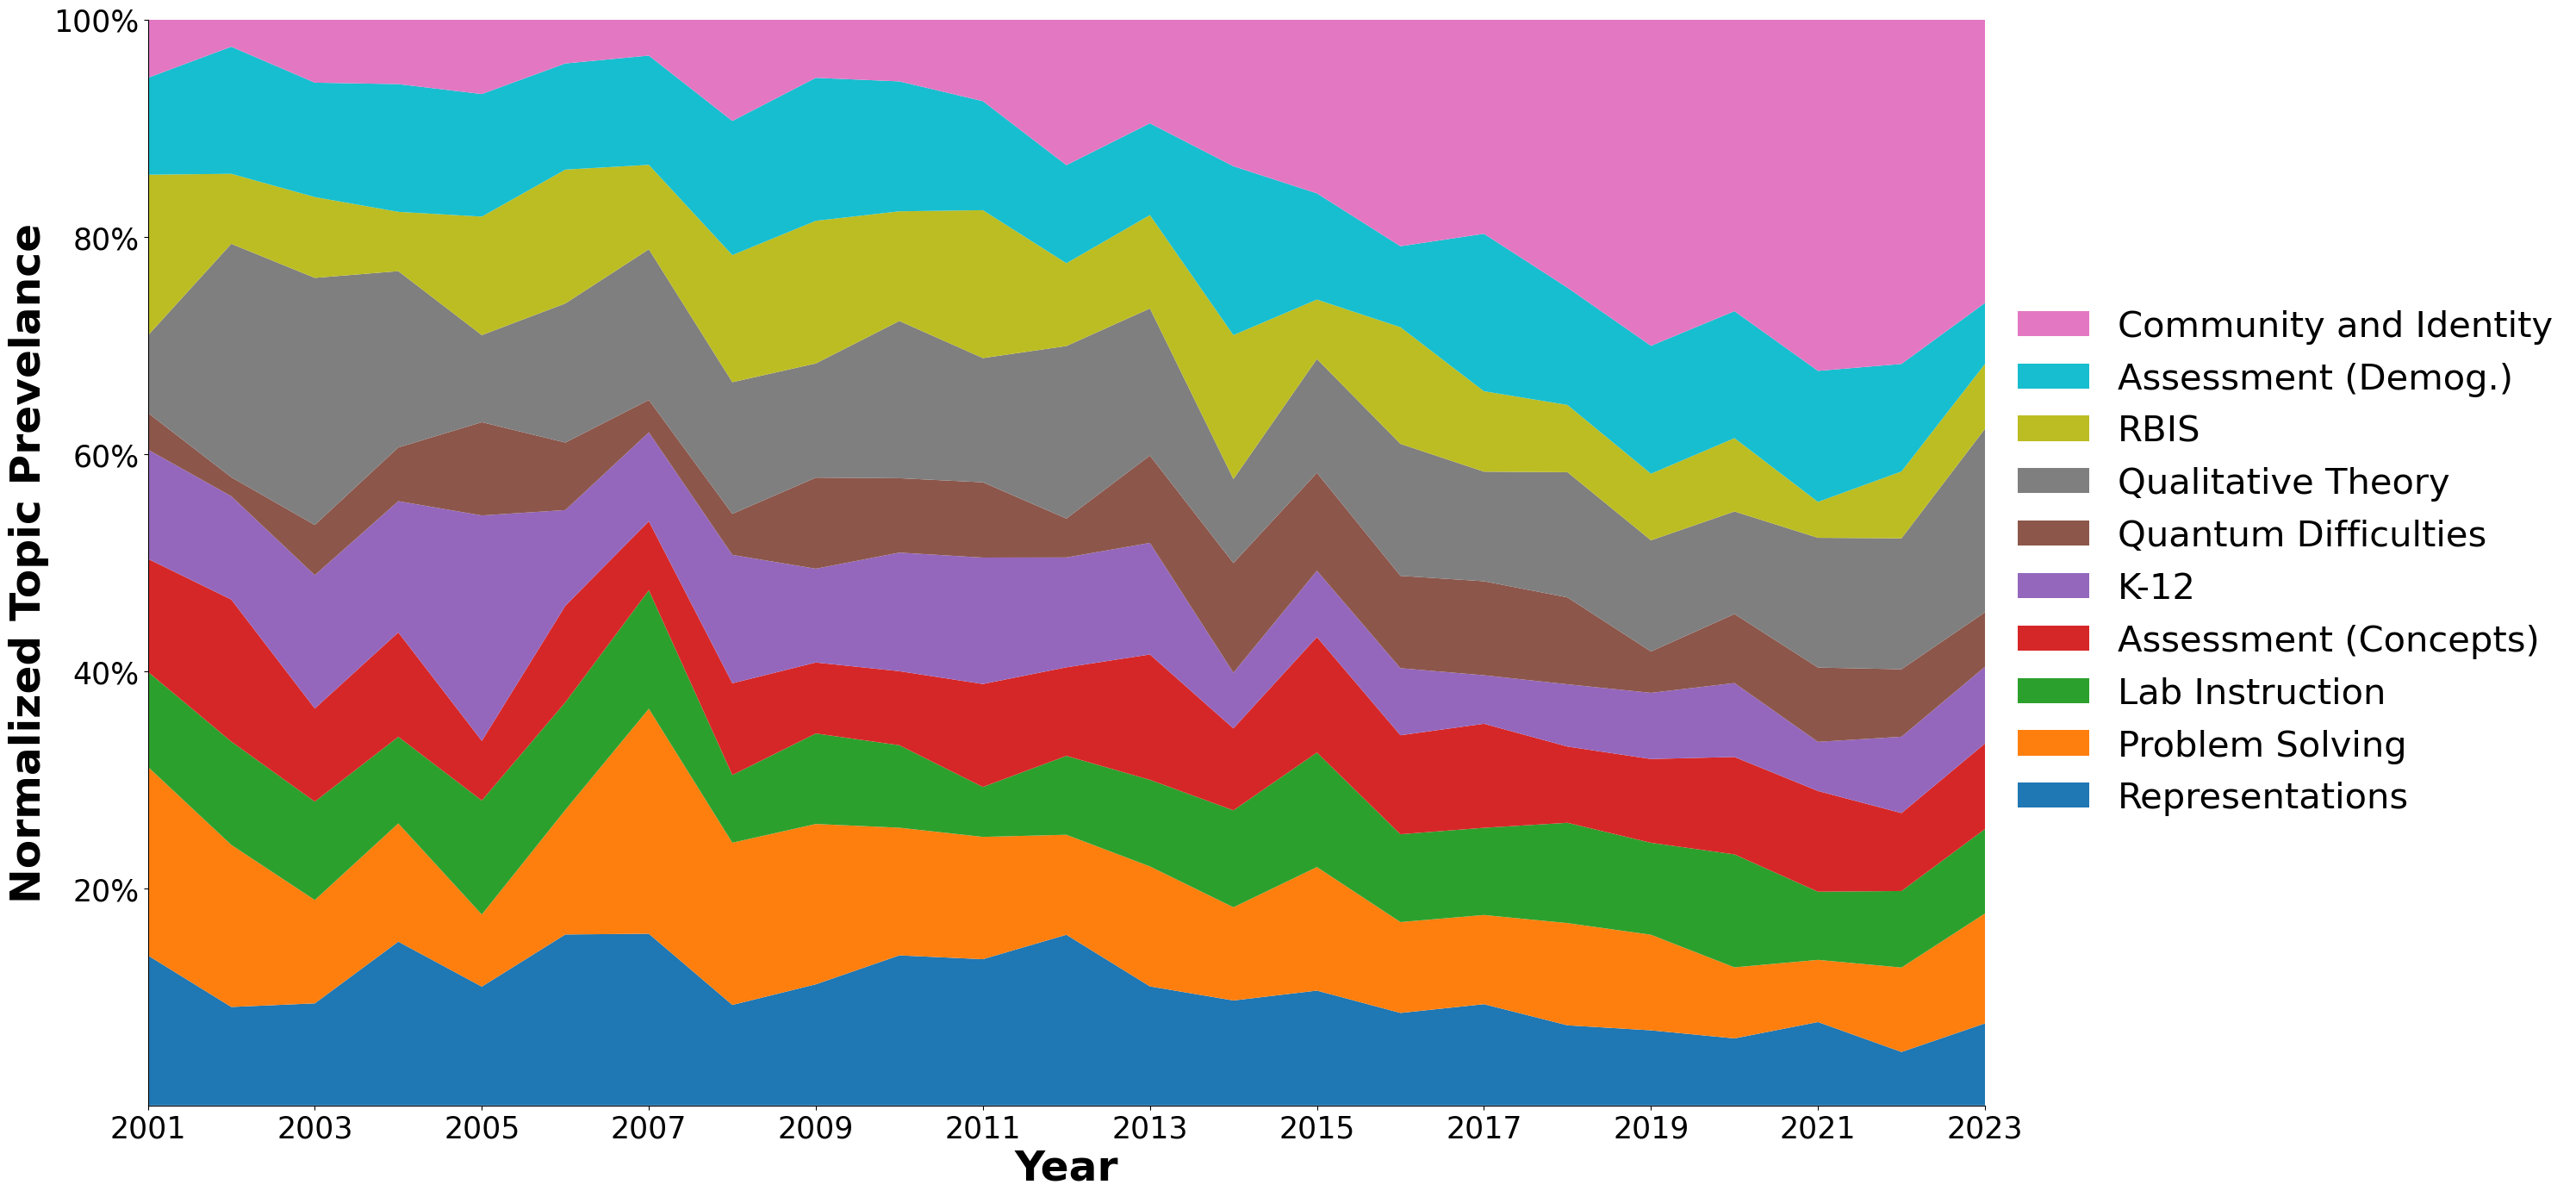

In [22]:
### LDA - stacked plot ###

# Create x-axis(year) for plotting stacked plot
years = df_LDA.sort_values(by=["year"], ascending=True).year.unique()
rolling_window = 1

# For storing y_data as matrix
y = np.zeros((len(LDA_category_names), len(years)))

# Loop over the categories
for i, col in enumerate(LDA_category_names):
    # y_z is the mean of the category for each year 
    y_z = df_LDA.groupby('year')[col].mean() 
    
    # If rolling_window > 1, then we need this to add "the smoothing" of rolling mean
    if rolling_window > 1:    
        y_z = y_z.rolling(rolling_window, min_periods=1, center=True).mean()
    y[i, :] = y_z

# Normalize the data for each year, sum over all topics (axis = 0)
y = y / y.sum(axis=0)[None, :] # [None, :] to get the right shape

# Using the function to plot the stacked plot
stacked_plot(x_data=years, y_data_matrix=y, 
             name_list=category_NameColor_dict.keys(),
             colors   =category_NameColor_dict.values())

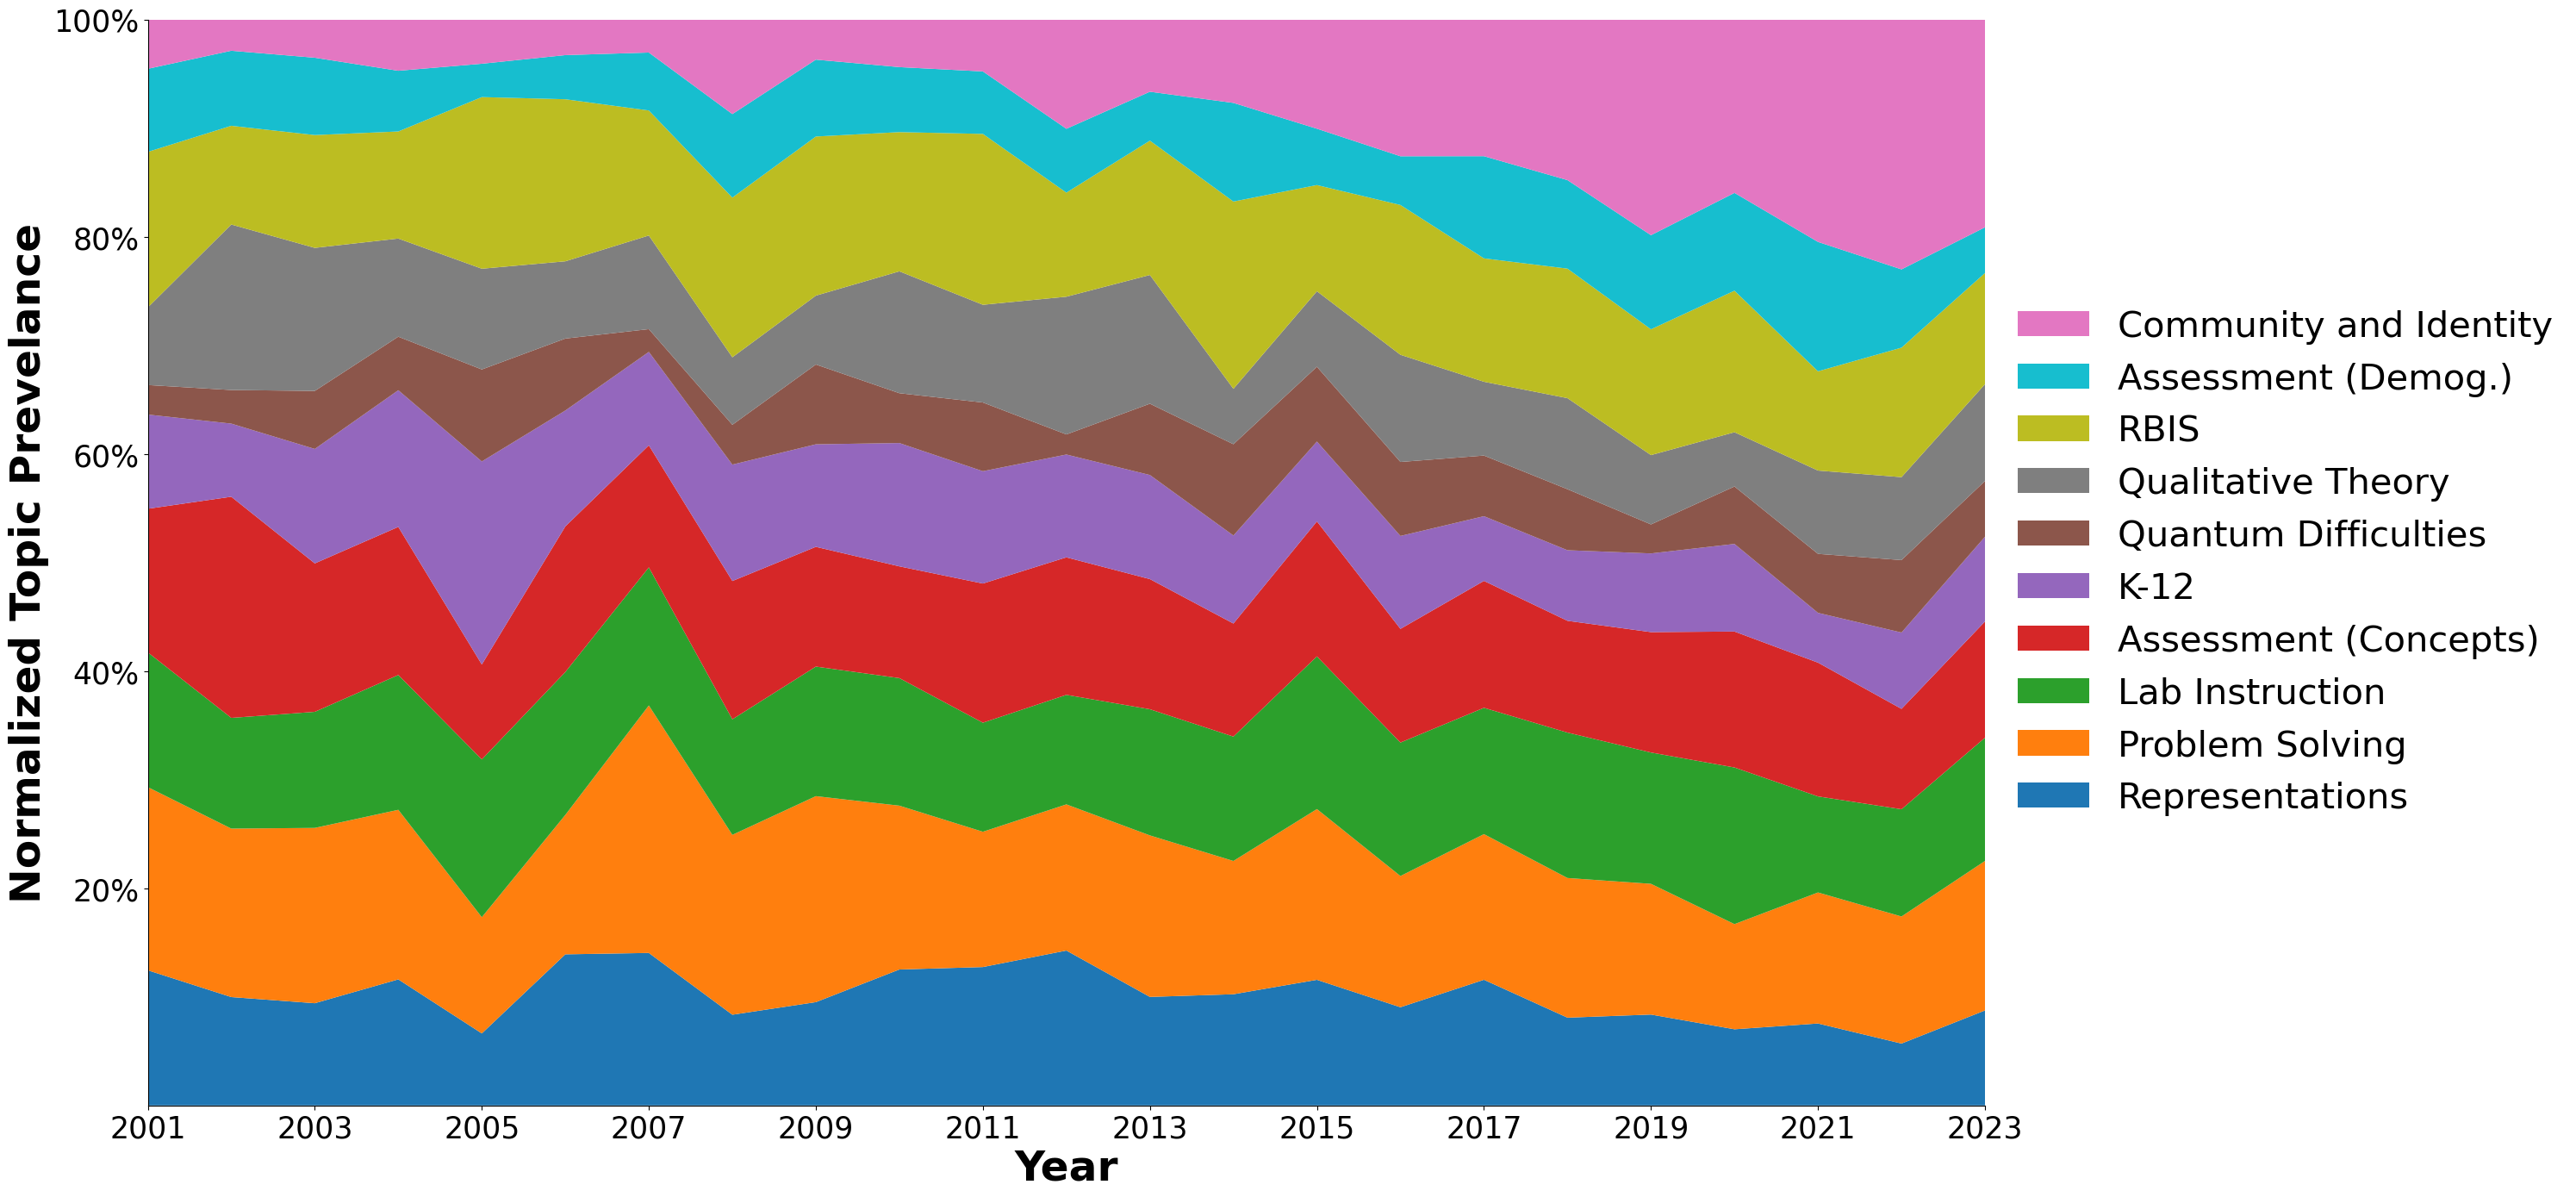

In [23]:
### Embedding - stacked plot ###

# Create x-axis(year) for plotting stacked plot
years = df_LDA.sort_values(by=["year"], ascending=True).year.unique()
rolling_window = 1

# For storing y_data as matrix
y = np.zeros((len(LDA_category_names), len(years)))

# Loop over the categories
for i, col in enumerate(LDA_category_names):
    # y_z is the mean of the category for each year 
    y_z = df_embeddings.groupby('year')[col].mean() 
    
    # If rolling_window > 1, then we need this to add "the smoothing" of rolling mean
    if rolling_window > 1:    
        y_z = y_z.rolling(rolling_window, min_periods=1, center=True).mean()
    y[i, :] = y_z

# Normalize the data for each year, sum over all topics (axis = 0)
y = y / y.sum(axis=0)[None, :] # [None, :] to get the right shape

# Using the function to plot the stacked plot
stacked_plot(x_data=years, y_data_matrix=y, 
             name_list=category_NameColor_dict.keys(),
             colors   =category_NameColor_dict.values())

The first plot, showing the stacked LDA, reveals a continuation of the trend of high prevalence of the "Community and Identity" category, noted in Odden et al. (2020)[[2]](#ref3). Similar trends can be seen in the plot for the embedding scores, though the trend is lower (i.e., around 20% of research on Community & Identity at its peak, whereas LDA rates this as 30%). There are also clearly higher prevalences of "Assessment", "Lab Instruction" and "Problem Solving" in the embeddings model, while "Qualitative Theory" has a lower prevalence.

Most notably, the two plots show many similar shifts over time, i.e., surges and falls of topics at the same locations, like Problem Solving around 2007.  

These differences and trends are unpacked more in the companion article.

<a class="anchor" id="four"></a> 
# 4. Embeddings Analysis using Researcher-Derived Categories
Our goal with the first application of this embeddings-based technique was to benchmark it against another NLP topic modeling technique, LDA. However, this has some drawbacks: namely, that the topics found by LDA aren't always the most useful from a human researcher perspective. For example, the topic Quantum Difficulties seems like it should really be a sub-category of Representations or Qualitative Theory. This is somewhat expected, since LDA finds topics based on clusters of co-occuring words, and papers that talk about quantum mechanics education use a very distinct vocabulary. But, the strength of the present approach is that we are free to define our topic categories however we want. So, to illustrate the versatility of this method, we will now perform a second analysis, using the same procedure as before, but this time using fully researcher-defined categories based on a 2012 literature review by [Docktor & Mestre](https://journals.aps.org/prper/abstract/10.1103/PhysRevSTPER.10.020119)[[3]](#ref2):

*Docktor, J. L., & Mestre, J. P. (2014). Synthesis of discipline-based education research in physics. Physical Review Special Topics - Physics Education Research, 10(2), 020119. https://doi.org/10.1103/PhysRevSTPER.10.020119*

<a class="anchor" id="four_a"></a> 
## 4.A. Loading new data

For this second analysis, we will be using a very similar dataset to the prior analysis, text from articles from the PERC proceedings literature. However, in order to improve the quality of the text embeddings, we have re-downloaded the articles and re-scraped the text using a more up-to-date text extraction tool, which allows us to retain some of the text organization from the 2-column PERC papers. We also have performed manual cleaning of approximately 100 articles that had a highest prevalence of obvious formatting issues (such as the inclusion of non-latin characters). These were generally articles pertaining to quantum physics, which usually include many formulas. This allowed us to retain a few articles that were dropped from the prior dataset due to these text issues, bringing our total corpus up to 1761 articles.

After doing this data preparation, we created embeddings of the text data and created a new dataframe in the same way as before. The dataframe has the following columns: 

- "title": title of the article
- "authors": authors of the article
- “PDF Link”: a link to the pdf of the article 
- “doi”: the article’s doi
- "year": the year the article was published
- "filename": the filename of the article
- “raw”: the raw text of the article, which we embed
- “embedding”: the embedding vector as a numpy array of 512 length 

We begin by importing this data:

In [24]:
with open("data/PERC2001-2023_ExtraArticles/embeddings_jina.pkl", "rb") as file:
    df = pickle.load(file)

print(df.shape)
print(df.columns)
expert_embedding_matrix = np.vstack(df["embedding"].values)

(1761, 8)
Index(['title', 'authors', 'PDF Link', 'doi', 'year', 'filename', 'raw',
       'embedding'],
      dtype='object')


<a class="anchor" id="four_b"></a> 
## 4.B. Indices

To define the new categories, the 4th author (TOBO) took the categories and sub-categories from the [literature review by Docktor & Mestre](https://journals.aps.org/prper/abstract/10.1103/PhysRevSTPER.10.020119), and, using a list of articles in the PERC proceedings, selected 4 representative articles for each sub-category aiming for a mix of authors and years[[3]](#ref2). Additionally, he added two categories present in the PERC proceedings but not in the literature review: Pre-College Physics Education, and Identity and Equity.

The indices for these articles are in a csv file, `data/DomainExpert/DomainExpert_Indecies.csv`. We import it below, and highlight the first article per category to show which sub-categories were included in each category. (Note that two sub-categories were dropped from the Docktor & Mestre review due to difficulty operationalizing them or thematic incompatability; more detail on this can be found in the companion article).

In [25]:
# Read in the datafile with the topics
filepath = "data/PERC2001-2023_ExtraArticles/chosen_centroids.csv"
df_topics = pd.read_csv(filepath, sep=",", encoding="ISO-8859-1", header=0, index_col=0)
df_topics.groupby("Sub-Category", sort=False).head(1) 

,Topic Number,Topic Name,Sub-Category,Paper Index,File name,Year,Paper name,Authors
0,1,Conceptual Understanding,Misconceptions,751,10.1119_perc.2013.pr.022.pdf,2013,Student Understanding of Blackbody Radiation a...,"Paul J. Emigh, Gina Passante, and Peter S. Sha..."
4,1,Conceptual Understanding,Conceptual Resources,1056,10.1119_perc.2016.pr.072.pdf,2016,Introductory Physics Students' Epistemological...,Erin M. Scanlon
8,1,Conceptual Understanding,Ontologies,749,10.1119_perc.2013.pr.020.pdf,2013,Negative Energy: Why Interdisciplinary Physics...,"Benjamin W. Dreyfus, Benjamin D. Geller, Julia..."
12,2,Problem Solving,Expert-Novice,90,10.1063_1.1807271.pdf,2003,Expert-Novice Comparisons to Illuminate Differ...,Kathleen A. Harper
16,2,Problem Solving,Worked Examples,1332,10.1119_perc.2019.pr.Chen.pdf,2019,Evaluating the effectiveness of two methods to...,"Z. Chen, K. M. Whitcomb, M. W. Guthrie, C. Singh"
20,2,Problem Solving,Representations,231,10.1063_1.2508713.pdf,2006,Comparing Explicit and Implicit Teaching of Mu...,"Patrick B. Kohl , David Rosengrant, and Noah D..."
24,2,Problem Solving,Mathematics,1006,10.1119_perc.2016.pr.022.pdf,2016,Drawing physical insight from mathematics via ...,"Mark Eichenlaub, Deborah Hemingway, and Edward..."
28,2,Problem Solving,Instructional Strategies,583,10.1063_1.3680046.pdf,2011,Do prescribed prompts prime sensemaking during...,"Mathew ""Sandy"" Martinuk and Joss Ives"
32,3,Curriculum and Instruction,Lecture,816,10.1119_perc.2014.pr.001.pdf,2014,Student Use of a Single Lecture Video in a Fli...,"John M. Aiken, Shih-Yin Lin, Scott S. Douglas,..."
36,3,Curriculum and Instruction,Recitation and discussion,179,10.1063_1.2177030.pdf,2005,A Preliminary Study of the Effectiveness of Di...,"Robert J. Endorf, Kathleen M. Koenig, and Greg..."


We will turn the data from this csv file into a dictionary:

In [26]:
# Dictionary with the topics(keys) and their corresponding sub-categories list(values)
topic_sub_category_dict =  df_topics.groupby("Topic Name", sort=False)["Sub-Category"].unique().apply(list).to_dict()
# Dictionary with the sub-categories(keys) and their corresponding indices as list(values)
sub_category_indices_dict = df_topics.groupby("Sub-Category", sort=False)["Paper Index"].apply(list).to_dict()
# Dictionary with the topics(keys) and their corresponding indices as list(values)
topic_indices_dict = df_topics.groupby("Topic Name", sort=False)["Paper Index"].apply(list).to_dict()

# Printing the sub-categories and their corresponding indices and topics pretty
# Print heading
heading_SC = "Sub category" + "-"*(40-len("Sub_category"))
heading_I = "Indices" + "-"*(30-len("Indices"))
print(heading_SC+ heading_I + "Topic Belonging") 
# Loop over the sub-categories and print them with their corresponding indices and topics
for topic_name, sub_category_list in topic_sub_category_dict.items():
    for sub_category in sub_category_list:
        sub_category_print = sub_category + " "*(40-len(sub_category))
        indices_print = str(sub_category_indices_dict[sub_category]) + " "*(30-len(str(sub_category_indices_dict[sub_category])))
        print(f"{sub_category_print}{indices_print}{topic_name}")

Sub category----------------------------Indices-----------------------Topic Belonging
Misconceptions                          [751, 124, 1186, 692]         Conceptual Understanding
Conceptual Resources                    [1056, 1119, 1435, 54]        Conceptual Understanding
Ontologies                              [749, 602, 1241, 911]         Conceptual Understanding
Expert-Novice                           [90, 276, 416, 346]           Problem Solving
Worked Examples                         [1332, 664, 899, 881]         Problem Solving
Representations                         [231, 1694, 492, 898]         Problem Solving
Mathematics                             [1006, 86, 662, 1649]         Problem Solving
Instructional Strategies                [583, 1211, 56, 334]          Problem Solving
Lecture                                 [816, 204, 38, 1162]          Curriculum and Instruction
Recitation and discussion               [179, 861, 1416, 424]         Curriculum and Instruction
Lab i

Now, we will re-order the topics for plotting later on:

In [27]:
# The order we want of the topics is:
topic_order = ["Problem Solving", "Pre-College", "Cognitive Psychology",
             "Attitudes and Beliefs", 'Curriculum and Instruction', 'Assessment',
             'Conceptual Understanding', 'Identity and Equity']
# Reorder the dictionary to match the order of the topics
topic_sub_category_dict = {key: topic_sub_category_dict[key] for key in topic_order}
# Reorder the dictionary to match the order of the topics
topic_indices_dict = {key: topic_indices_dict[key] for key in topic_order}

print("The topics are:")
for key in topic_sub_category_dict.keys():
    print(" - "+key)

expert_topic_indices = list(topic_indices_dict.values())
expert_topic_names = list(topic_indices_dict.keys())

The topics are:
 - Problem Solving
 - Pre-College
 - Cognitive Psychology
 - Attitudes and Beliefs
 - Curriculum and Instruction
 - Assessment
 - Conceptual Understanding
 - Identity and Equity


Let's print some items from the dictionary to show how the topic/sub-topic/index structure works:

In [28]:
# Print here is to show how it works
expert_topic_indices_2 = []
for topic, sub_category_list in topic_sub_category_dict.items():
    print(topic)
    print(sub_category_list)
    list_of_indices = list(map(lambda x: sub_category_indices_dict[x], sub_category_list))
    print(list_of_indices)
    print("\n")
    expert_topic_indices_2.append(list_of_indices)

Problem Solving
['Expert-Novice', 'Worked Examples', 'Representations', 'Mathematics', 'Instructional Strategies']
[[90, 276, 416, 346], [1332, 664, 899, 881], [231, 1694, 492, 898], [1006, 86, 662, 1649], [583, 1211, 56, 334]]


Pre-College
['Teaching Tools', 'Teacher Preparation', 'Teaching Strategies', 'Student Experiences']
[[1687, 590, 1325, 750], [165, 645, 1645, 521], [322, 548, 1054, 591], [876, 57, 996, 641]]


Cognitive Psychology
['Knowledge and memory', 'Attention', 'Novice-Expert', 'Learning']
[[268, 146, 252, 1066], [939, 1536, 455, 1712], [715, 416, 90, 276], [894, 81, 245, 219]]


Attitudes and Beliefs
['Student Attitudes', 'Faculty Beliefs', 'TA and LA beliefs']
[[220, 606, 1064, 371], [376, 14, 1331, 188], [462, 1081, 327, 636]]


Curriculum and Instruction
['Lecture', 'Recitation and discussion', 'Lab instruction', 'Structural Changes', 'Instructional Materials and Strategies']
[[816, 204, 38, 1162], [179, 861, 1416, 424], [633, 1063, 1399, 130], [832, 1607, 562, 330

We will also define a color-scheme for the topics, though we want to differentiate it from the LDA topics before (while also making it accessible to folks with color-blindness)

/var/folders/yt/z2xnrlfj5374g780cxtyt9s00000gq/T/ipykernel_21664/2753541644.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(0, 11-i, c=value, s=100, label=key)


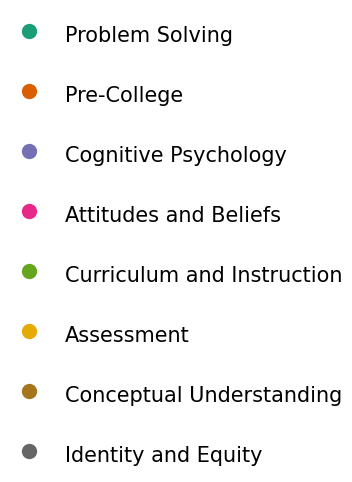

In [29]:
colors = [plt.cm.Dark2(i) for i in range(len(expert_topic_names))]
topic_NameColor_dict = dict(zip(expert_topic_names, colors))
# The key is the name, and color is the value

plt.figure(figsize=(0.5, 6))
for i, (key, value) in enumerate(topic_NameColor_dict.items()):
    plt.scatter(0, 11-i, c=value, s=100, label=key)
    plt.text(0.1, 11-(i+0.175), key, fontsize=15)
plt.axis('off')
plt.show()

<a class="anchor" id="four_c"></a> 
## 4.C. Distance metrics, scaling functions, and hyperparameters

For consistency's sake, we will be using a cosine similarity measure with an exponential scaling function in this analysis. Here, we won't have any way to benchmark results against another analysis, but this approach worked previously which suggests that it can be useful here as well. However, it is not clear a-priori which alpha value we should use. This will significantly impact the analysis, as a lower alpha value causes more homogeneous topic scores, i.e., every topic recieves more similar scores. Conversely, a higher value causes a sharper distinction in high and lower scores. In the present analysis, we want to encourage the model to assign high primary topic scores (since this makes it more easy to interpret model results, and is similar to how a human researcher might approach a literature review task), so we have chosen an alpha value of 200.  

In [30]:
alpha = 200
metric = "cosine"
scaling = "exponential"

# Calculate the embedding score for each category with the embedding score
embedding_scores_8 = embedding_score(expert_embedding_matrix, alpha, expert_topic_indices, metric, scaling, rounding=False)

# Add the embedding scores to the DataFrame
for i, key in enumerate(expert_topic_names):
    df[str(key)] = embedding_scores_8[:,i]
df.head(3)

,title,authors,PDF Link,doi,year,filename,raw,embedding,Problem Solving,Pre-College,Cognitive Psychology,Attitudes and Beliefs,Curriculum and Instruction,Assessment,Conceptual Understanding,Identity and Equity
0,Inductive Influence of Related Quantitative an...,Philip Dukes and David E. Pritchard,https://www.per-central.org/../items/perc/990.pdf,10.1119/perc.2001.inv.001,2001,10.1119_perc.2001.inv.001.pdf,(Invited paper for proceedings of Physics Educ...,"[-0.33143284916877747, -0.31065312027931213, 0...",0.712535,0.002751,0.111263,0.006388,0.022099,0.141435,0.003511,0.000019
1,An Investigation on the Impact of Implementing...,Lawrence T. Escalada,https://www.per-central.org/../items/perc/1023...,10.1119/perc.2001.inv.002,2001,10.1119_perc.2001.inv.002.pdf,An Investigation on the Impact of Implementing...,"[-0.47120609879493713, -0.35588982701301575, 0...",0.021562,0.276075,0.002641,0.010733,0.407089,0.003090,0.277877,0.000933
2,Context in the Context of Physics and Learning,Noah D. Finkelstein,https://www.per-central.org/../items/perc/1025...,10.1119/perc.2001.inv.003,2001,10.1119_perc.2001.inv.003.pdf,Context in the Context of Physics and Learning...,"[-0.3976055681705475, -0.33022406697273254, 0....",0.010125,0.291208,0.026794,0.023009,0.024194,0.002099,0.614865,0.007707


In [31]:
# I want to calculate distances from the articles to the centroids and plot them as a histogram
def embedding_distances(embedding_matrix, alpha, centroid_indices, metric, scaling, rounding=False): 
    # Check that the input is valid
    assert scaling in ["exponential", "power"]
    assert metric in ["cosine", "euclidean", "cityblock"]

    # Normalizing the embedding matrix
    embedding_matrix /= np.linalg.norm(embedding_matrix, axis=1)[:,None]
    
    # Calculating centroid vectors
    centroid = np.zeros((len(centroid_indices), len(embedding_matrix[0])))
    for i in range(len(centroid_indices)):
        embeddings_temp = np.array([embedding_matrix[index] for index in centroid_indices[i]])
        centroid[i] = np.mean(embeddings_temp, axis=0)
        
    # Calculating distances using scipy.spatial.distance.cdist function
    distances = sc.spatial.distance.cdist(embedding_matrix, centroid, metric=metric)
    
    # Calculate the percentage in difference between the largest and smallest distance for each article
    percentage_difference = (1-np.min(distances, axis=1)/np.max(distances, axis=1))
    return distances

d = embedding_distances(expert_embedding_matrix, alpha, expert_topic_indices, metric, scaling, rounding=False)
print(d[0])
print(d[1])
print(d[2])
"""print(np.max(d[0]))
print(np.min(d[0])/np.max(d[0]))
d_0 = d[0]/np.sum(d[0])
print(d_0)
print(np.min(d_0)/np.max(d_0))"""

[0.04114922 0.06893369 0.0504339  0.06472138 0.05851565 0.04923417
 0.06771375 0.09389428]
[0.08480493 0.07205613 0.09530374 0.08829292 0.07011433 0.09451813
 0.07202359 0.10050735]
[0.07193848 0.05514353 0.06707287 0.06783438 0.06758318 0.07980653
 0.0514067  0.07330322]


'print(np.max(d[0]))\nprint(np.min(d[0])/np.max(d[0]))\nd_0 = d[0]/np.sum(d[0])\nprint(d_0)\nprint(np.min(d_0)/np.max(d_0))'

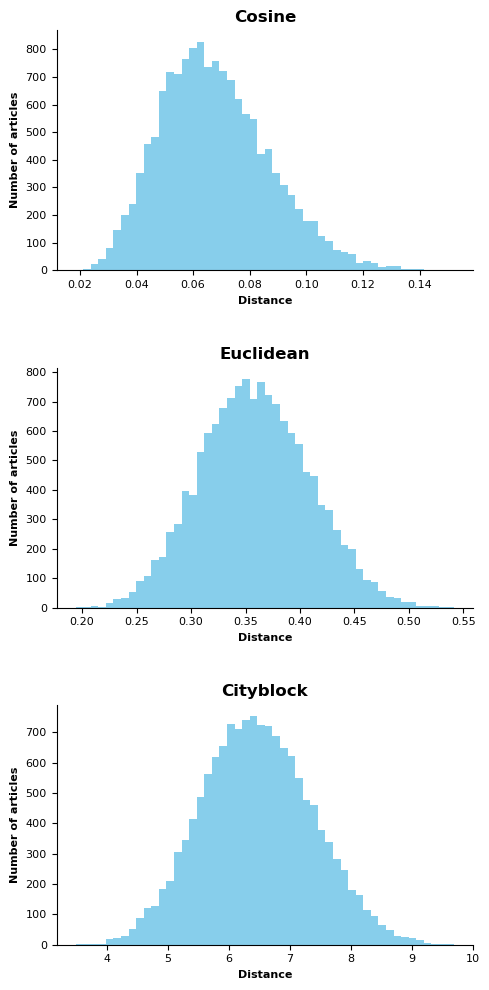

In [32]:
# Plotting the histogram of the distances for different metrics with subplots in a for loop
fig, axs = plt.subplots(3, 1, figsize=(5, 10))
for i, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    distances = embedding_distances(expert_embedding_matrix, alpha, expert_topic_indices, metric, scaling, rounding=False)
    axs[i].hist(distances.flatten(), bins=50, color="skyblue")
    axs[i].set_title(metric.capitalize(), fontsize=12, fontweight='bold')
    axs[i].set_xlabel("Distance", fontsize=8, fontweight='bold')
    axs[i].set_ylabel("Number of articles", fontsize=8, fontweight='bold')
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].tick_params(axis='both', which='major', labelsize=8)
fig.tight_layout(h_pad=3)
plt.show()

As a check on what this choice of alpha value means for our model, we again plot a histogram of primary, secondar, and tertiary topic scores.

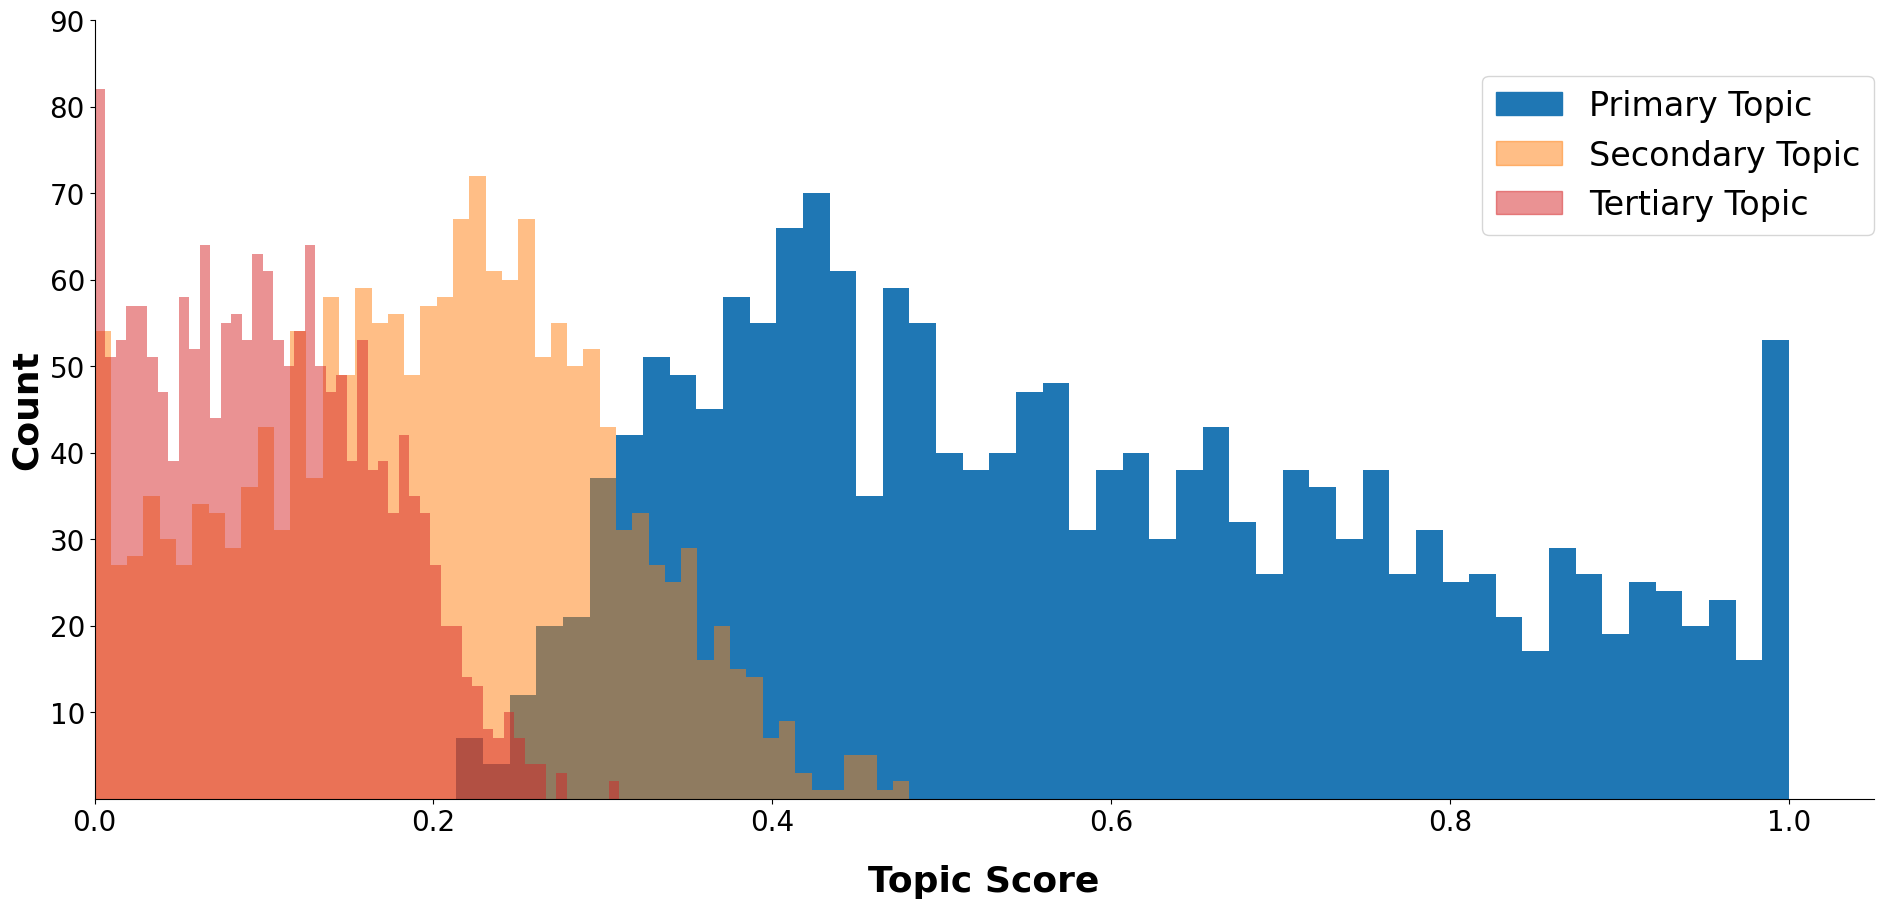

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(20,10), sharex=True, sharey=True)

colors = ["C0", "C1", "C3"]

labels=["Primary Topic", "Secondary Topic", "Tertiary Topic"]
handles = [mpatches.Patch(color=colors[0], label=labels[0]),
           mpatches.Patch(color=colors[1], alpha=0.5, label=labels[1]),
           mpatches.Patch(color=colors[2], alpha=0.5, label=labels[2])]



axs.hist(np.max(embedding_scores_8, axis=1), bins=50, color=colors[0])
axs.hist(np.partition(embedding_scores_8, -2, axis=1)[:, -2], bins=50, alpha=0.5, color=colors[1])
axs.hist(np.partition(embedding_scores_8, -3, axis=1)[:, -3], bins=50, alpha=0.5, color=colors[2])

axs.set_ylabel("Count", fontsize=26, fontweight='bold')
axs.set_xlabel("Topic Score", fontsize=26, labelpad=20, fontweight='bold')

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.tick_params(which='both', bottom=True, top=False, labelbottom=True, labelsize=20)
axs.set_xlim(left=0)
axs.legend(handles=handles, labels=labels, fontsize=24, loc='upper center', bbox_to_anchor=(0.89, 0.95))

    
axs.set_yticks(axs.get_yticks()[1:])
fig.tight_layout( pad=4.0)
plt.show()

Here, it's clear that we still have a mixed topic model. An alpha of 200 has led to a significant fraction of articles being scored as approximately 100% of one topic (bump at 1.0 for primary topic scores) and a histogram generally shifted towards 1; however, the peak is still around 0.45, so many papers still get mixed topic scores.

<a class="anchor" id="four_d"></a> 
## 4.D. Face validity: articles with high topic scores, mean topics scores, and approximately 50% topic scores

Using the same heatmap visualization as before, we present snapshots of three different sets of articles: those with highest prevalence of a single topic, those with approximately mean prevalence of each topic, and those with approximately 50% prevalence (which isn't always the mean).

In [34]:
colors = [(1, 0.95, 0.95), (1, 0.4, 0.5), (0.9, 0.3, 0.4), 
            (0.8, 0.2, 0.3), (0.7, 0.1, 0.2), (0.5, 0.05, 0.1)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

legend_patches = [mpatches.Patch(color='white', label=(f'{i+1}: {category}')) for i, category in enumerate(expert_topic_names)]

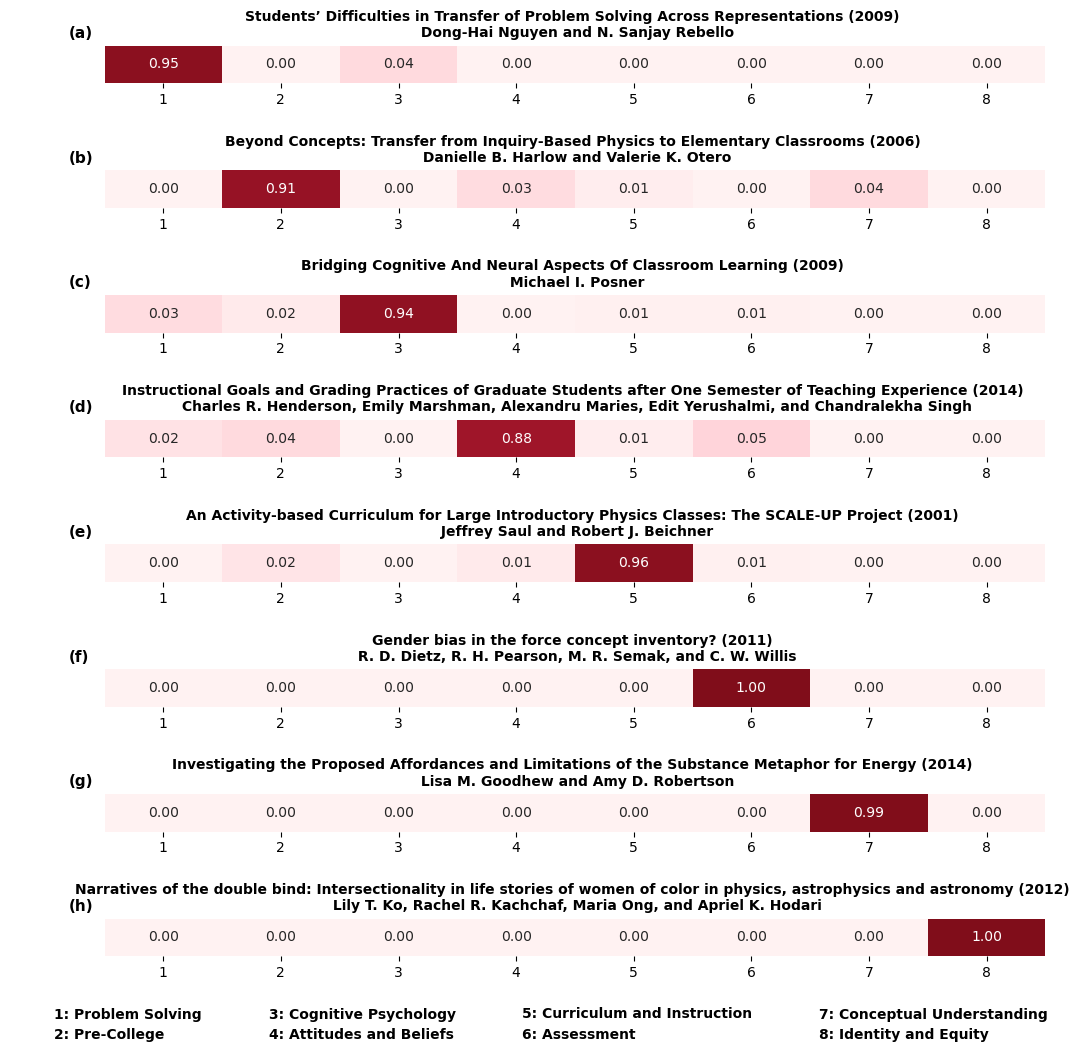

In [35]:
# Calculate top articles
heatmap_indices = []
scores_list = []
title_list = []

for i, category in enumerate(embedding_scores_8.T):
    # Sort the articles in the category by embedding score
    sorted_articles = np.argsort(category)[::-1]
    # Remove the articles that are part of the expert centroid articles
    sorted_articles = np.array([article for article in sorted_articles if article not in expert_topic_indices[i]])
    # Add the top three articles to the matrix
    heatmap_indices.append(sorted_articles[0])
    scores_list.append([embedding_scores_8[sorted_articles[0], :]])
        
    title_list.append(f'{df["title"][sorted_articles[0]]} ({df["year"][sorted_articles[0]]}) \n {df["authors"][sorted_articles[0]]}')

fig, axs = plt.subplots(8,1, figsize=(10, 10))
fig, axs = plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap)
plt.show()

These articles can be considered representative of each topic, as they have close to 100% of each topic. Inspection of the titles shows that each is well-aligned with the content of its respective topic: for example, article (e), 100% assessment, references the Force Concept Inventory (a research-based conceptual assessment in physics), while article (h), 100% Identity and Equity, references women of color, and article (c), 94% Cognitive Psychology, references cognitive and neural aspects of physics learning. These results suggest that our analysis is identifying representative articles that make sense given the topic definitions.

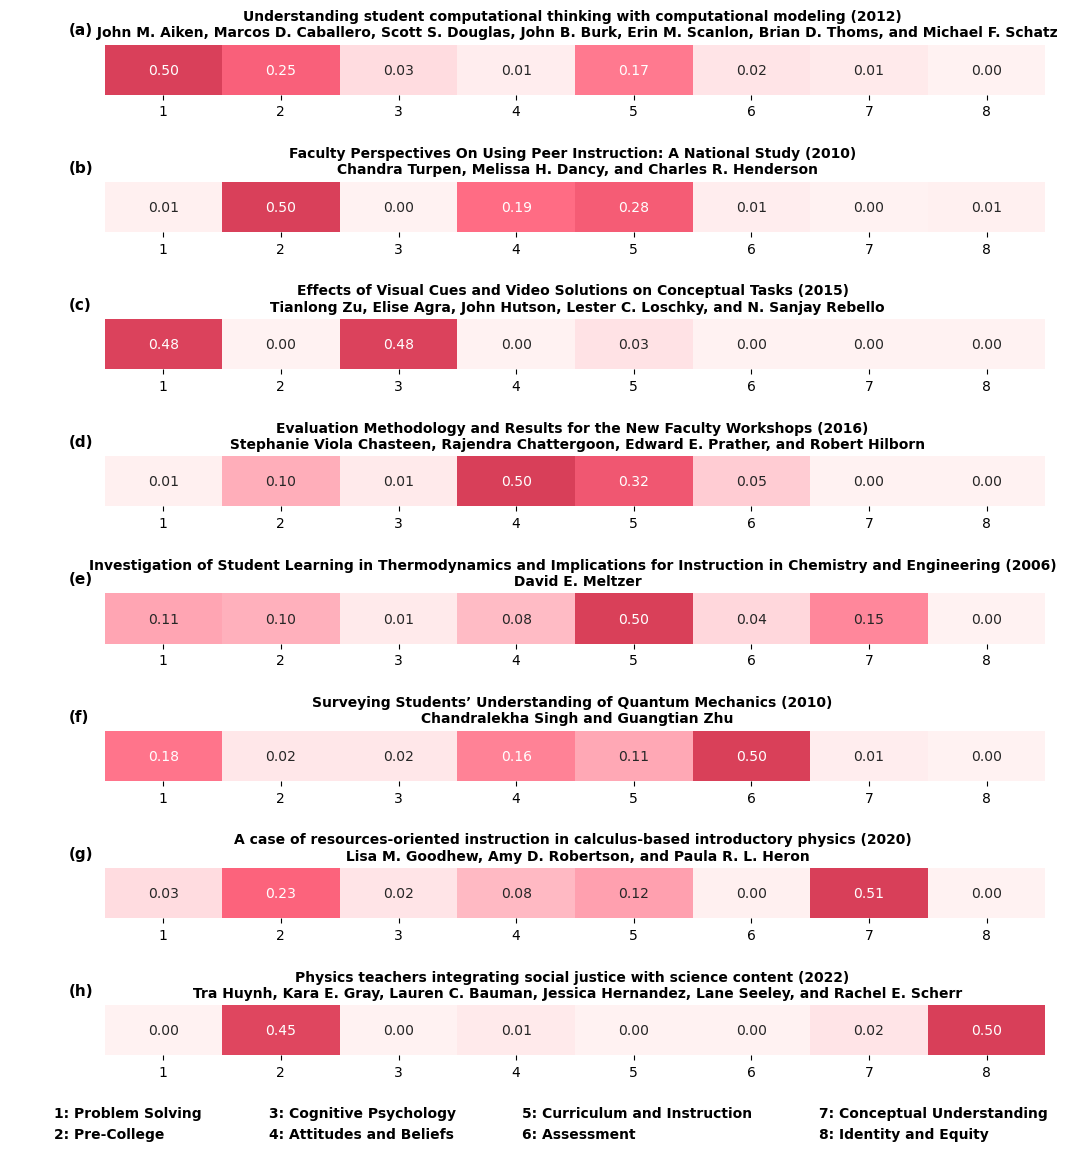

In [36]:
# Now I want to make a list with eight indices of the articles that are 
# closest to 0.50 in the embedding score for each category
heatmap_indices = []
scores_list = []
title_list = []

for i, category in enumerate(embedding_scores_8.T):
    # Sort the atricles in the costest to 0.5 for category 
    sorted_articles = np.argsort(np.abs(category - 0.50))
    # Remove the articles that are part of the expert centroid articles
    sorted_articles = np.array([article for article in sorted_articles if article not in expert_topic_indices[i]])
    index = sorted_articles[0]
    
    heatmap_indices.append(index)
    scores_list.append([embedding_scores_8[index, :]])
    title_list.append(f'{df["title"][index]} ({df["year"][index]}) \n {df["authors"][index]}')

fig, axs = plt.subplots(8,1, figsize=(10, 11))             
fig, axs = plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap)
plt.show()

These examples of articles with approximately 50% prevalence of each topic. As one can see, the topic scores fequently make sense: for example, *Physics teachers integrating social justice with science content* is approximately 50% Identity and Equity, 45% Pre-College physics education. In places where the results are less straightforward, one can often get a better understanding by skimming through the text: for example, *Improving student understanding of Dirac notation by using analogical reasoning in the context of a three-dimensional vector space,* was rated as 50% Problem-Solving, 30% Curriculum and Instruction; this study focused on students solving quantum mechanics problems (hence the Problem Solving) but inspection of the text reveals that it was based on a research-based instructional strategy called the Quantum Interactive Learning Tutorial which likely led to Curriculum and Instruction as the secondary topic.

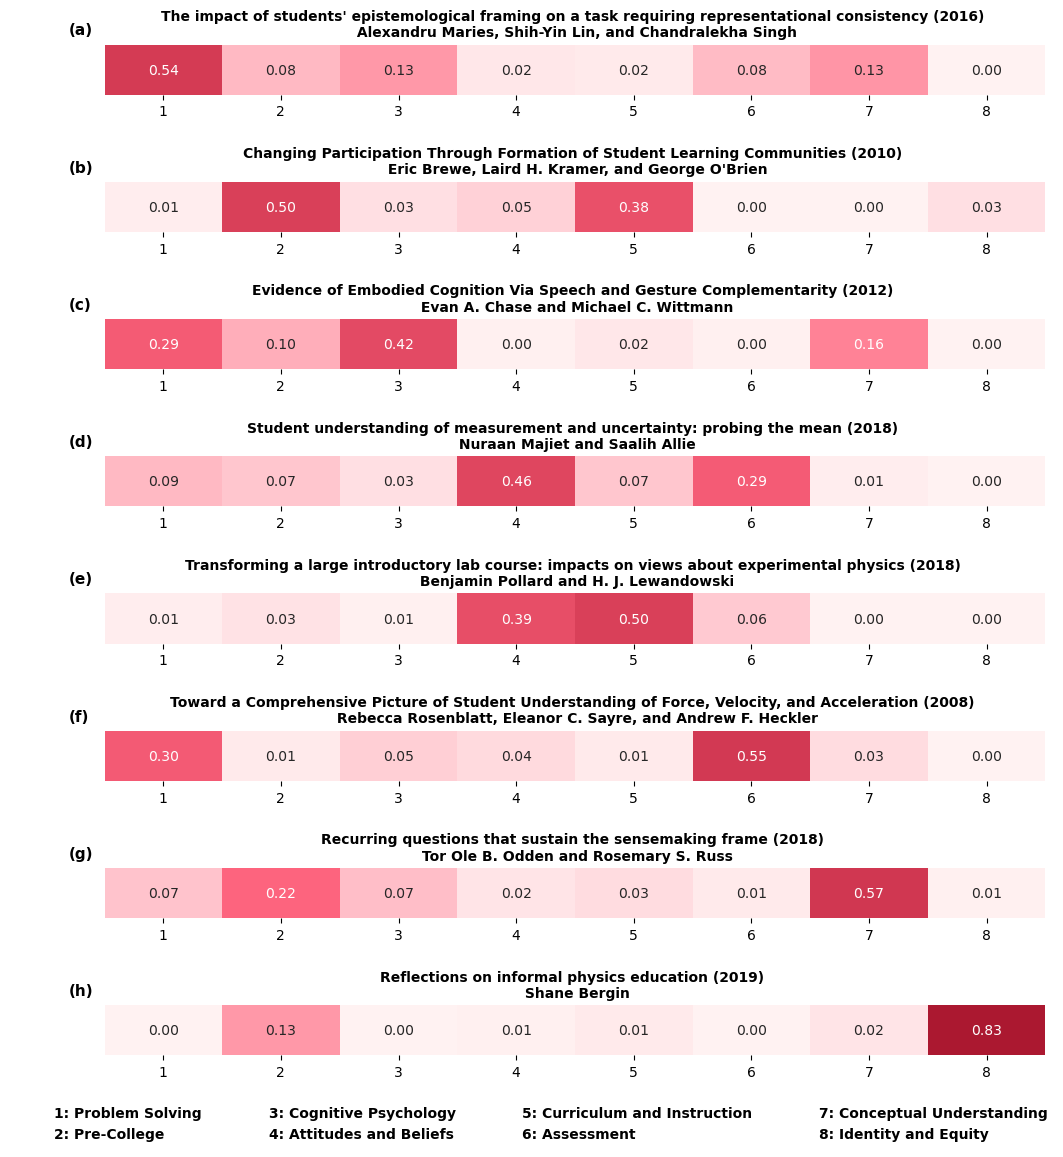

In [37]:
# Now I want to find another way of representing mid scores
# This time I want to make a list that includes eight lists with the indices 
# of the articles that have a given topic as their argmax

heatmap_indices = []
scores_list = []
title_list = []

mid_8 = [[] for i in range(8)]

# flatten the list of lists
expert_topic_indices_3 = [item for sublist in expert_topic_indices for item in sublist]

for i, scores in enumerate(embedding_scores_8):
    # Skip if article is in the expert centroid articles
    if i in expert_topic_indices_3:
        continue
    # Sort the articles by their max category
    mid_8[np.argmax(scores)].append(i)

for i in range(8):
    # Lets find the middle article for each category
    given_list = mid_8[i]
    given_scores = np.argsort(embedding_scores_8[given_list, i])
    middle_index = given_list[given_scores[len(given_scores)//2]]
    
    heatmap_indices.append(middle_index)
    scores_list.append([embedding_scores_8[middle_index, :]])
    title_list.append(f'{df["title"][middle_index]} ({df["year"][middle_index]}) \n {df["authors"][middle_index]}')

fig, axs = plt.subplots(8,1, figsize=(10, 11))
fig, axs = plot_heatmap(fig, axs, scores_list, title_list, legend_patches, cmap)
plt.show()

These articles are representative of those with approximately mean topic prevalence from each primary topic. One interesting thing to note is that some topics clearly had high mean prevalences, like Identity and Equity; these topics seem to be quite distinct and easy for the model to identify, as opposed to topics like Cognitive Psychology and Attitudes and Beliefs (which often are used as assessment methods or metrics in studies on other topics). Here again, however, the results make quite a bit of sense: *Recurring questions that sustain the sensemaking frame* (a graduate paper by the fourth author, TOBO), is 57% Conceptual Understanding (since it focuses on reasoning) and 22% Pre-College (since it skews towards science education research, rather than pure physics education research). *Transforming a large introductory lab course: impacts on views about experimental physics* is 50% Curriculum and Instruction (since it focuses on a lab course) and 39% Attitudes and Beliefs (since it focuses on view of experimental physics).

<a class="anchor" id="four_e"></a> 
## 4.E. Plotting topic prevalence as a function of time

Next, we use the same stacked area plot function as before to examine the normalized prevalence of these new topics as a function of time. This will let us see if there are any major shifts in the research on these topics, according to this model:

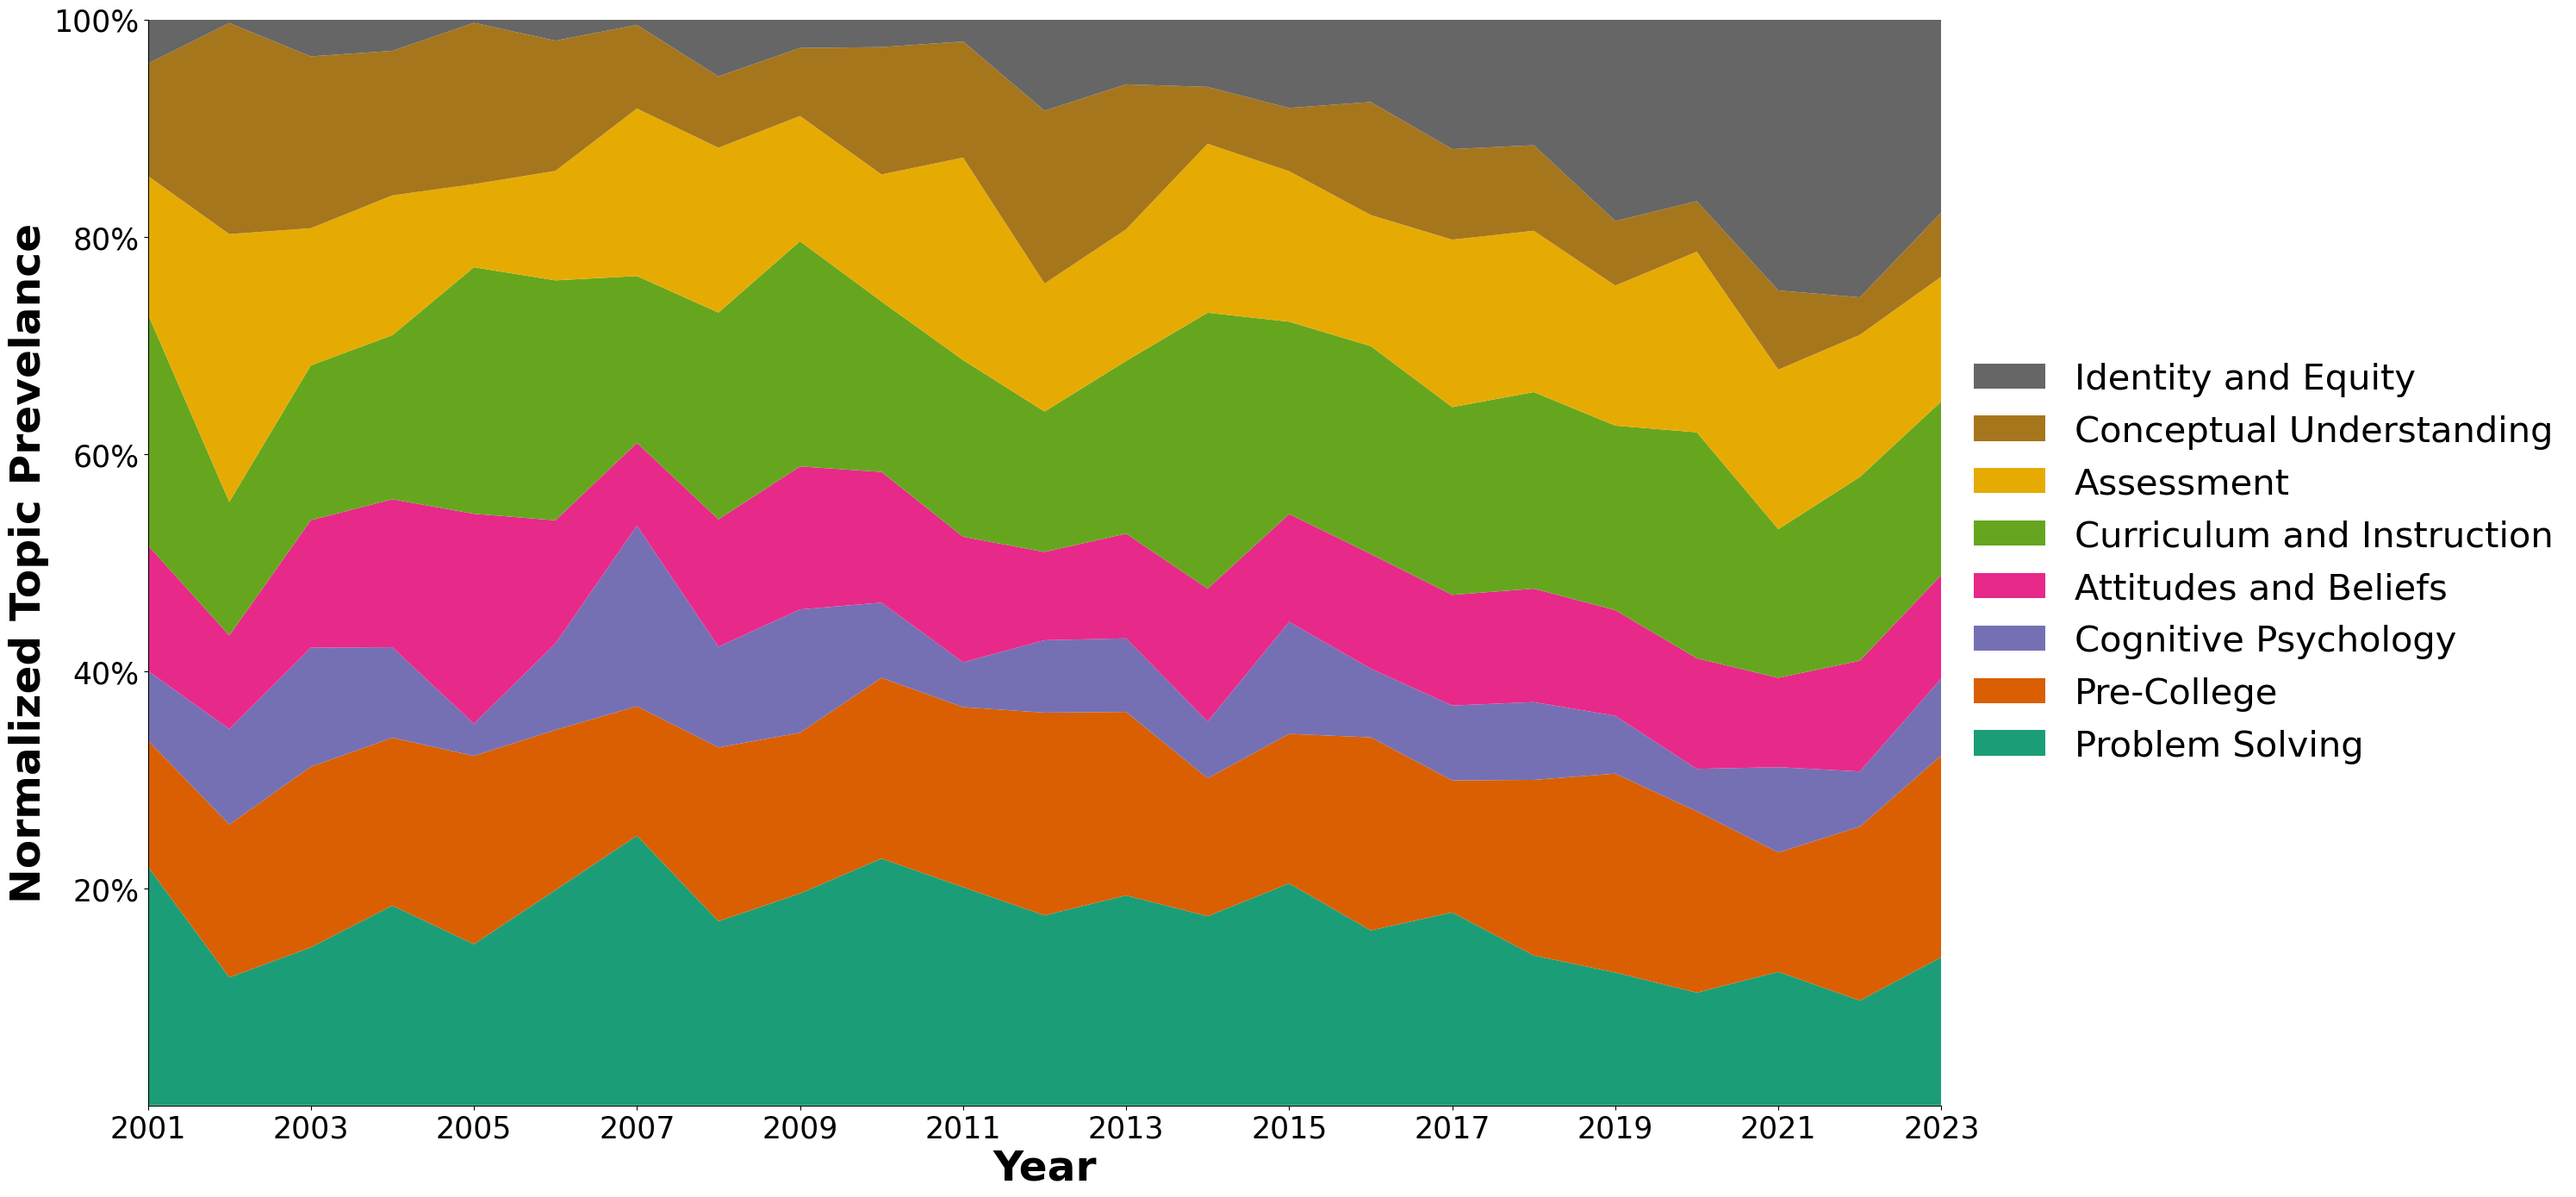

In [38]:
y = np.zeros((len(expert_topic_names), len(years)))
for i, col in enumerate(expert_topic_names):
    y_z = df.groupby('year')[col].mean()
    y_z = y_z.rolling(1, min_periods=1, center=True, win_type='triang').mean()
    y[i, :] = y_z
row_sums = y.sum(axis=0)
y_normalized = y / row_sums[np.newaxis, :]

stacked_plot(years, y_normalized, expert_topic_names, topic_NameColor_dict.values())

A few major trends stand out: first, Identity and Equity has grown significantly since the beginning of the analyzed time period, which is in line with the results from both the LDA and LDA-derived embeddings analysis. Conversely, research on Conceptual Understanding has waned somewhat. Notably, however, this analysis suggests that all topics have seen some amount of research interest over time, and most remain of interest to the community up to the present day. It also lets use quantify that interest: for example, suggesting that Identity and Equity has taken up approximately 20% of the research interest at its peak.

<a class="anchor" id="four_f"></a> 

## 4.F. Plotting cumulative prevalence as a function of time, and evaluating sensitivity to centroid choice

An important aspect of this method is that it depends on the specific articles one chooses to define the centroids. This means that the analytic choices of the researcher will always have some amount of downstream effects on the eventual analysis, even though this is a mostly unsupervised technique. So, we would like to understand what effects these choices have on eventual topic scores.

To estimate this sensitivity, we will use a sub-sampling procedure to re-define our topic centroids and see how much variation there is in topic scores with different centroids. Specifically, we will sample 3 out of 4 articles from every sub-category, and use these to define alternate centroids, then calculate topic scores with these alternate centroids. We will repeat this procedure 1000 times, and use the standard deviation of the resulting topic scores to put some error bars on our dataset.

In [39]:
import random as random

def sample_from_groups(centroid_indices, n):
    sample_indices = []
    for topic_indices in centroid_indices:
        topic_list = []
        for subtopic_indices in topic_indices:
            topic_list += random.sample(subtopic_indices, n)
        sample_indices.append(topic_list)
    return sample_indices

In [40]:
num_runs = 1000
num_samples = 3
alpha = 200
metric = "cosine"
scaling = "exponential"

In [41]:
# Tensor of all scores
all_scores = np.zeros((num_runs, len(df), len(expert_topic_indices_2)))

func = np.sum
years = range(df.year.min(), df.year.max()+1)

sample_array = []
for i in range(num_runs):
    sample_array.append(sample_from_groups(expert_topic_indices_2, num_samples))
    embedding_scores = embedding_score(expert_embedding_matrix, alpha, sample_array[i], metric, scaling)
    all_scores[i] = embedding_scores
    

# A matrix for storing the mean values and std for each category per year
mean_matrix = np.zeros((len(years), len(expert_topic_names)))
std_matrix = np.zeros((len(years), len(expert_topic_names)))

for i, year in enumerate(years):
    indices = np.where(df.year == year)[0]
    
    for j in range(len(expert_topic_names)):
        
        temp_list = []    
        for k in range(num_runs):
            temp_list.append(sum(all_scores[k, indices, j]))
            # The sum here takes the sum of all the articles score per category per year

        mean_matrix[i, j] = np.mean(temp_list)
        std_matrix[i, j] = np.std(temp_list)

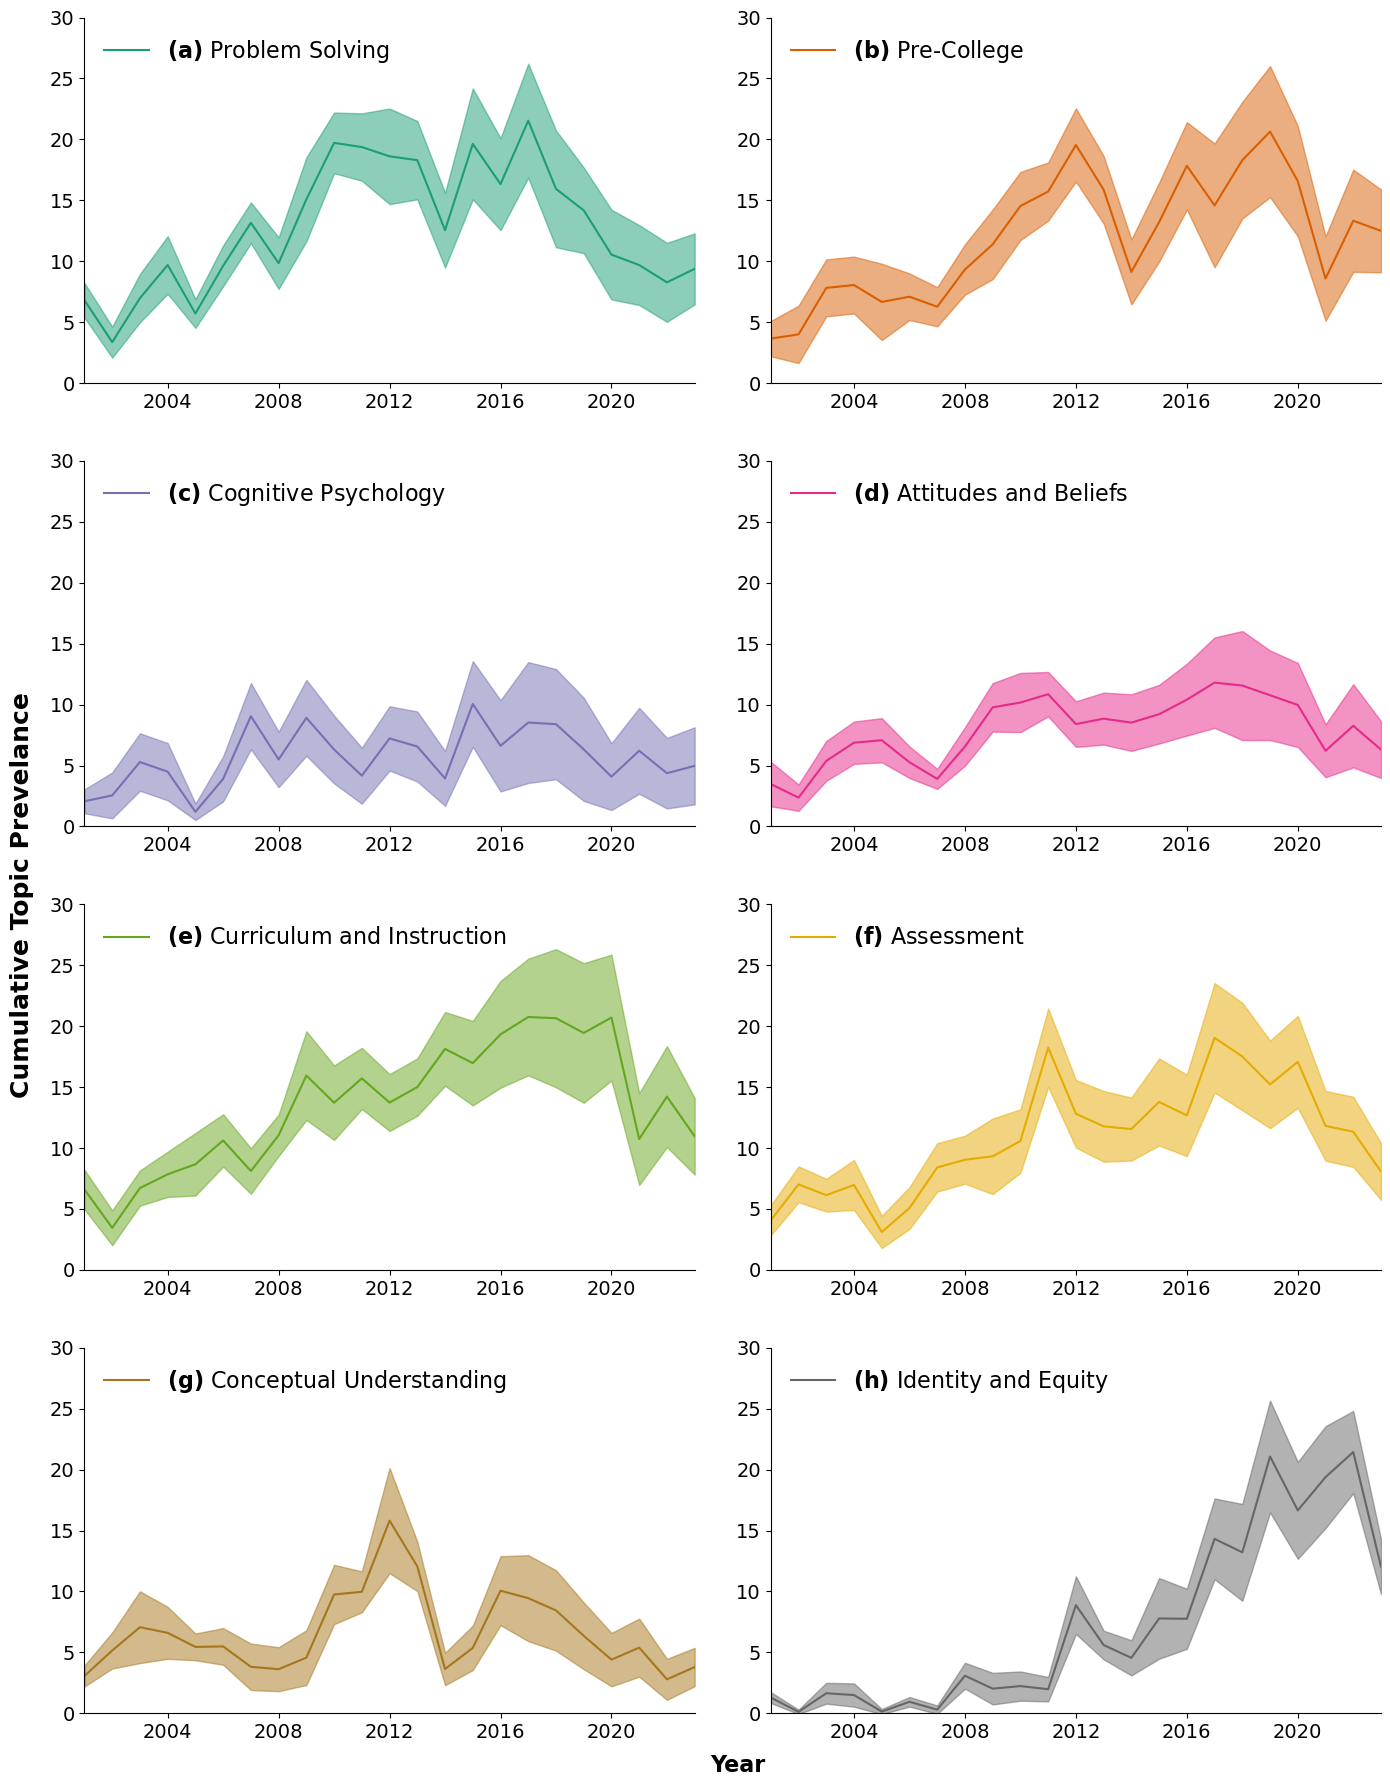

In [42]:
fig = plt.figure(figsize=(14,18))

# Create a list of the alphabet
alphabet = list(string.ascii_lowercase)

for i, name in enumerate(expert_topic_names):
    ax = fig.add_subplot(4,2,i+1)
    y = mean_matrix[:,i]
    err = 3*std_matrix[:,i]
    line, = ax.plot(years,y, color=topic_NameColor_dict[name])
    ax.fill_between(years, y-err, y+err, color = line.get_color(), alpha=0.5);
    ax.legend([fr"$\bf{{({alphabet[i]})}}$ {name}"], loc="upper left", fontsize=16, edgecolor='none');
    ax.set_xlim([2001,2023]);
    ax.set_xticks([2004,2008,2012,2016,2020]);
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylim([0,30]);
    ax.spines[['top', 'right']].set_visible(False)
    
fig.supylabel("Cumulative Topic Prevelance", fontsize=18, x=0.01, fontweight='bold')
fig.supxlabel("Year", fontsize=16, y=0.01, x=0.53, fontweight='bold')
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

In the plot above, the line is our topic prevalence including all 4 articles from every sub-category (it is, intuitively the closest to the mean of the 1000 resampling runs).

As we can see above, even with the resampling procedure, the overall trends are still visible. Certain topics have high variance, but these tend to be the ones with low prevalence (Cognitive Psychology and Attitudes and Beliefs), and often are included as secondary methods or topics for other studies—for example, eye-tracking (Cognitive Psychology) as a measure of problem-solving, or student attitudes (Attitudes and Beliefs) in active learning environments. These results suggest that, although there is some sensitivity to different centroids, the overall trends remain visible, which suggests that the model we have created (and the corresponding analysis technique) has some robustness.

<a class="anchor" id="five"></a> 
# 5. Discussion and Conclusions

<a class="anchor" id="five_a"></a> 
## 5.A. Reflections on the method

First off, going in to this project it was not clear whether text embeddings would be at all usable to do topic modeling in this way. The fact that the results have such high amounts of face-validity is frankly quite surprising, and speaks to the sophistication of the LLMs and embeddings for capturing and comparing semantic meaning. The topic scores above were based on very small differences between embeddings vectors; yet, these differences yield very intuitive topic scores.

This method is quite versatile. It doesn't require the same kind of data cleaning as a bag-of-words model (i.e., no removal of stop-words, numbers, puncutation, creation of bi-grams, etc.); it scales easily to different datasets (since distance calculations are based on the number of articles times the number of centroids); one can easily add or subtract data from the corpus without changing the underlying model (unlike inductive methods like LDA); one can change the LLM used for embeddings without affecting any of the downstream code; one can easily redefine centroids, and add or remove topics with only minor recalculation necessary; and, only a small number of texts is required to define centroids, which can then be used to score as many texts as one would like.

At the same time, there are clearly some challenges with the method. One is the fact that some articles end up having very low topic scores smeared across many different topics. From one perspective, this is to be expected, as in any qualitative analysis project there will always be "edge cases", pieces of data that are not easy to classify into any particular group, code, or topic. Interestingly, this technique might actually allow us to easily identify these "edge cases" (by looking for the characteristic topic "smear") and thereby allow researchers to adjust their coding scheme accordingly. Another challenge is the fact that it's not clear that a single general-purpose embeddings vector is enough to thoroughly capture the meaning of a text. It's possible that one would want to use multiple vectors (i.e., a "path" through the meaning space) or domain-adapted LLM to better capture and differentiate these meanings. Another challenge is the fact that once a text has been turned into an embedding, it is not possible to "read out" the embedding back into text. This would be highly desirable, as one might for example be able to use a centroid vector to generate text and thereby verify that it is in fact capturing the meanings a researcher is after. However, with the current embeddings techniques one essentially does a lossy compression of meaning from the text into the embedding, and this compression only goes one way. 

<a class="anchor" id="five_b"></a> 
## 5.B. Future work and applications

This project acts as a proof-of-concept that embeddings can be used for the purposes of deductive qualitative data analysis at scale. The next step is to expand the scope of this analysis to include other types of datasets like survey responses or interview transcripts, other forms of coding, like mutually-exclusive categories, and perhaps explore inductive as well as deductive applications. We are also interested in exploring other LLMs for creating embeddings (especially LLMs that have been domain-adapted to our specific context), represent text using multiple embeddings vectors, and explore the space of other distance metrics and transformation functions. Finally, we wish to understand the properties of these "meaning spaces": their topologies, how they encapsulate and differentiate different concepts and meanings, and how we can use their structure to perform tasks that were previously only doable with time-intesive human labor.

The development of these NLP tools is still ramping up. We suspect that in the space of only a few more years, the process of qualtiative data analysis (and the kinds of questions we can answer using these methods) will likely look very different from that which has been used for the last 100+ years.

<a class="anchor" id="five_c"></a> 
## 5.C. Conclusion

We have, in this notebook and the companion article, demonstrated a method for applying cutting edge NLP methods to the problem of performing qualitative data analysis at scale. Using current large language models and their embedding applications, we have projected textual data into a vector space that allows us to quantitatively compare semantic meanings. This approach clearly has great potential for future analyses, and we look forward to seeing how it is taken up and refined by the research community.

<a class="anchor" id="citations"></a>

# 6. Citations
<a id="ref1">[1]</a> Aggarwal, C.C., Hinneburg, A., Keim, D.A. (2001). On the Surprising Behavior of Distance Metrics in High Dimensional Space. In: Van den Bussche, J., Vianu, V. (eds) Database Theory — ICDT 2001. ICDT 2001. Lecture Notes in Computer Science, vol 1973. Springer, Berlin, Heidelberg. https://doi.org/10.1007/3-540-44503-X_27


<a id="ref3">[2]</a>  Odden, T. O. B., Marin, A., & Caballero, M. D. (2020). Thematic Analysis of 18 Years of Physics Education Research Conference Proceedings using Natural Language Processing. Physical Review Physics Education Research, 16(1), 10142. https://doi.org/10.1103/PhysRevPhysEducRes.16.010142


<a id="ref2">[3]</a>  Docktor, J. L., & Mestre, J. P. (2014). Synthesis of discipline-based education research in physics. Physical Review Special Topics - Physics Education Research, 10(2), 020119. https://doi.org/10.1103/PhysRevSTPER.10.020119


